# Análisis Exploratorio de Datos (EDA)
## Análisis descriptivo de datos agregados por estación y franja horaria

## 1. Configuración inicial

In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats as scipy_stats

warnings.filterwarnings('ignore')

In [21]:
# Rutas de datos
DATA_DIR = Path('../data_processed')
INPUT_CSV = DATA_DIR / 'datos_aggregados_dia_estacion_franja.csv'

In [22]:
# Cargar datos
df = pd.read_csv(INPUT_CSV, parse_dates=['date'])
print(f"Total de registros: {len(df):,}")
print(f"Columnas: {df.columns.tolist()}")
df.head()

Total de registros: 301,694
Columnas: ['date', 'anio', 'mes', 'dia', 'hora', 'estacion', 'franja_horaria', 'parametro', 'valor', 'clase']


,date,anio,mes,dia,hora,estacion,franja_horaria,parametro,valor,clase
0,2023-01-01 07:00:00,2023,1,1,7,SUR,pico_7_9,CO,1.03,0
1,2023-01-01 08:00:00,2023,1,1,8,SUR,pico_7_9,CO,0.88,0
2,2023-01-01 10:00:00,2023,1,1,10,SUR,ref_10_12,CO,0.89,0
3,2023-01-01 11:00:00,2023,1,1,11,SUR,ref_10_12,CO,0.88,0
4,2023-01-02 07:00:00,2023,1,2,7,SUR,pico_7_9,CO,1.38,0


In [23]:
# Crear dataset solo con franja pico
df_pico = df[df['franja_horaria'] == 'pico_7_9'].copy()

print("DIMENSIONES FINALES DEL DATASET DE TRABAJO")
print("=" * 90)

# Dataset completo (ambas franjas)
print("\nDATASET COMPLETO (Franja 7-9h + Franja 10-12h):")
print(f"   • Dimensión:           {df.shape}")
print(f"   • Registros totales:   {len(df):,}")
print(f"   • Variables:           {df.shape[1]}")
print(f"   • Columnas:            {', '.join(df.columns.tolist())}")

# Dataset solo franja pico
print("\nDATASET ENFOQUE PRINCIPAL (Solo Franja Pico 7-9h):")
print(f"   • Dimensión:           {df_pico.shape}")
print(f"   • Registros totales:   {len(df_pico):,}")
print(f"   • Variables:           {df_pico.shape[1]}")
print(f"   • % del dataset total: {(len(df_pico)/len(df)*100):.2f}%")

# Distribución por clase en franja pico
print("\nDISTRIBUCIÓN POR CLASE (Franja Pico 7-9h):")
clase_counts = df_pico['clase'].value_counts().sort_index()
for clase, count in clase_counts.items():
    clase_nombre = "Sin clases (Vacaciones)" if clase == 0 else "Con clases"
    pct = (count / len(df_pico)) * 100
    print(f"   • Clase {clase} ({clase_nombre}): {count:,} registros ({pct:.2f}%)")

# Información adicional
print("\nINFORMACIÓN TEMPORAL:")
print(f"   • Fecha inicial:       {df_pico['date'].min()}")
print(f"   • Fecha final:         {df_pico['date'].max()}")
print(f"   • Días únicos:         {df_pico['date'].dt.date.nunique():,}")

print("\nINFORMACIÓN ESPACIAL:")
print(f"   • Estaciones únicas:   {df_pico['estacion'].nunique()}")
print(f"   • Estaciones:          {', '.join(sorted(df_pico['estacion'].unique()))}")

print("\nINFORMACIÓN DE CONTAMINANTES:")
print(f"   • Contaminantes:       {df_pico['parametro'].nunique()}")
print(f"   • Tipos:               {', '.join(sorted(df_pico['parametro'].unique()))}")

print("=" * 90)

DIMENSIONES FINALES DEL DATASET DE TRABAJO

DATASET COMPLETO (Franja 7-9h + Franja 10-12h):
   • Dimensión:           (301694, 10)
   • Registros totales:   301,694
   • Variables:           10
   • Columnas:            date, anio, mes, dia, hora, estacion, franja_horaria, parametro, valor, clase

DATASET ENFOQUE PRINCIPAL (Solo Franja Pico 7-9h):
   • Dimensión:           (149974, 10)
   • Registros totales:   149,974
   • Variables:           10
   • % del dataset total: 49.71%

DISTRIBUCIÓN POR CLASE (Franja Pico 7-9h):
   • Clase 0 (Sin clases (Vacaciones)): 97,730 registros (65.16%)
   • Clase 1 (Con clases): 52,244 registros (34.84%)

INFORMACIÓN TEMPORAL:
   • Fecha inicial:       2023-01-01 07:00:00
   • Fecha final:         2025-06-30 08:00:00
   • Días únicos:         912

INFORMACIÓN ESPACIAL:
   • Estaciones únicas:   6
   • Estaciones:          CENTRO, NORESTE3, NOROESTE3, NORTE2, SUR, SUROESTE2

INFORMACIÓN DE CONTAMINANTES:
   • Contaminantes:       5
   • Tipos:        

## 2. Funciones auxiliares para estadísticas descriptivas

In [24]:
def calcular_estadisticas_completas(serie):
    """
    Calcula estadísticas descriptivas completas para una serie numérica.
    """
    from scipy import stats
    
    return pd.Series({
        'media': serie.mean(),
        'mediana': serie.median(),
        'moda': serie.mode()[0] if len(serie.mode()) > 0 else np.nan,
        'minimo': serie.min(),
        'maximo': serie.max(),
        'rango': serie.max() - serie.min(),
        'varianza': serie.var(),
        'desv_std': serie.std(),
        'Q1': serie.quantile(0.25),
        'Q2': serie.quantile(0.50),
        'Q3': serie.quantile(0.75),
        'IQR': serie.quantile(0.75) - serie.quantile(0.25),
        'n': len(serie)
    })

## 3. Análisis descriptivo general de la variable `valor`

In [25]:
stats_general = calcular_estadisticas_completas(df['valor'])
stats_general_df = pd.DataFrame(stats_general, columns=['Estadístico General'])

print("=" * 60)
print("ANÁLISIS DESCRIPTIVO GENERAL - VARIABLE 'VALOR'")
print("=" * 60)
print(stats_general_df.to_string())
print("=" * 60)

ANÁLISIS DESCRIPTIVO GENERAL - VARIABLE 'VALOR'
          Estadístico General
media               26.628928
mediana             17.000000
moda                12.000000
minimo               0.000000
maximo            1000.000000
rango             1000.000000
varianza          1129.827411
desv_std            33.612905
Q1                   5.200000
Q2                  17.000000
Q3                  34.460000
IQR                 29.260000
n               301694.000000


## 4. Análisis descriptivo agrupado por ESTACIÓN

In [26]:
stats_estacion = df.groupby('estacion')['valor'].apply(calcular_estadisticas_completas).unstack()

print("=" * 80)
print("ANÁLISIS DESCRIPTIVO POR ESTACIÓN")
print("=" * 80)
print(stats_estacion.to_string())
print("=" * 80)

ANÁLISIS DESCRIPTIVO POR ESTACIÓN
               media  mediana  moda  minimo  maximo    rango     varianza   desv_std   Q1      Q2     Q3    IQR        n
estacion                                                                                                                
CENTRO     28.683458   20.380  10.0    0.09   601.0   600.91   968.999292  31.128753  7.1  20.380  38.10  31.00  21131.0
NORESTE3   25.836721   16.500  11.0    0.00  1000.0  1000.00  1139.078991  33.750244  6.0  16.500  33.00  27.00  57050.0
NOROESTE3  24.668884   13.615   6.0    0.00   636.0   636.00   978.343515  31.278483  3.9  13.615  33.00  29.10  53888.0
NORTE2     27.876462   18.000  12.0    0.05   692.0   691.95  1228.113189  35.044446  6.0  18.000  35.00  29.00  43159.0
SUR        25.975910   16.900  13.0    0.00   729.0   729.00  1088.631848  32.994421  5.0  16.900  34.00  29.00  83825.0
SUROESTE2  29.168760   19.400   8.0    0.05   773.0   772.95  1353.573145  36.790938  6.3  19.400  36.95  30.65  42641.

## 5. Análisis descriptivo agrupado por FRANJA HORARIA

In [27]:
stats_franja = df.groupby('franja_horaria')['valor'].apply(calcular_estadisticas_completas).unstack()

print("=" * 80)
print("ANÁLISIS DESCRIPTIVO POR FRANJA HORARIA")
print("=" * 80)
print(stats_franja.to_string())
print("=" * 80)

ANÁLISIS DESCRIPTIVO POR FRANJA HORARIA
                    media  mediana  moda  minimo  maximo   rango     varianza   desv_std      Q1    Q2     Q3      IQR         n
franja_horaria                                                                                                                  
pico_7_9        23.474426     14.1   6.0     0.0  1000.0  1000.0   906.327925  30.105281  4.9000  14.1  29.94  25.0400  149974.0
ref_10_12       29.747129     20.0  20.0     0.0   773.0   773.0  1331.202613  36.485649  6.2475  20.0  39.00  32.7525  151720.0


## 6. Análisis descriptivo agrupado por CLASE

In [28]:
stats_clase = df.groupby('clase')['valor'].apply(calcular_estadisticas_completas).unstack()

print("=" * 80)
print("ANÁLISIS DESCRIPTIVO POR CLASE")
print("=" * 80)
print("Clase 0 = Periodo fuera de clases")
print("Clase 1 = Periodo de clases")
print("=" * 80)
print(stats_clase.to_string())
print("=" * 80)

ANÁLISIS DESCRIPTIVO POR CLASE
Clase 0 = Periodo fuera de clases
Clase 1 = Periodo de clases
           media  mediana  moda  minimo  maximo   rango     varianza   desv_std   Q1    Q2    Q3   IQR         n
clase                                                                                                           
0      25.429281     16.0  12.0     0.0  1000.0  1000.0  1033.192172  32.143307  5.0  16.0  33.0  28.0  196734.0
1      28.877512     19.0  12.0     0.0   773.0   773.0  1303.215578  36.100077  6.0  19.0  37.0  31.0  104960.0


## 7. Análisis descriptivo agrupado por ESTACIÓN + FRANJA HORARIA + CLASE

In [29]:
stats_combinado = df.groupby(['estacion', 'franja_horaria', 'clase'])['valor'].apply(calcular_estadisticas_completas).unstack()

print("=" * 100)
print("ANÁLISIS DESCRIPTIVO POR ESTACIÓN + FRANJA HORARIA + CLASE")
print("=" * 100)
print(stats_combinado.to_string())
print("=" * 100)

ANÁLISIS DESCRIPTIVO POR ESTACIÓN + FRANJA HORARIA + CLASE
                                    media  mediana  moda  minimo  maximo    rango     varianza   desv_std       Q1      Q2      Q3      IQR        n
estacion  franja_horaria clase                                                                                                                      
CENTRO    pico_7_9       0      23.740208   16.000  10.0    0.11   486.0   485.89   657.930893  25.650164   6.0000  16.000  32.000  26.0000   5612.0
                         1      26.226110   18.015  10.0    0.09   375.0   374.91   834.751394  28.892065   6.0000  18.015  34.185  28.1850   4876.0
          ref_10_12      0      31.078891   23.300  31.0    0.32   601.0   600.68  1077.213110  32.820925   9.0000  23.300  42.000  33.0000   5699.0
                         1      33.956917   25.000  23.0    0.19   470.0   469.81  1262.221975  35.527763  10.5975  25.000  45.000  34.4025   4944.0
NORESTE3  pico_7_9       0      23.373405   14.

## 8. Resumen de resultados clave

In [30]:
print("\n" + "="*80)
print("RESUMEN DE HALLAZGOS PRINCIPALES")
print("="*80)

print("\n1. Estación con mayor promedio de contaminación:")
print(stats_estacion['media'].sort_values(ascending=False).head(1))

print("\n2. Franja horaria con mayor promedio de contaminación:")
print(stats_franja['media'].sort_values(ascending=False))

print("\n3. Diferencia entre periodos de clases y vacaciones:")
print(stats_clase['media'])

print("\n4. Combinación con mayor contaminación promedio:")
top_combo = stats_combinado['media'].sort_values(ascending=False).head(3)
print(top_combo)

print("\n5. Variabilidad por estación (coeficiente de variación):")
cv_estacion = (stats_estacion['desv_std'] / stats_estacion['media'] * 100).sort_values(ascending=False)
print(cv_estacion)

print("="*80)


RESUMEN DE HALLAZGOS PRINCIPALES

1. Estación con mayor promedio de contaminación:
estacion
SUROESTE2    29.16876
Name: media, dtype: float64

2. Franja horaria con mayor promedio de contaminación:
franja_horaria
ref_10_12    29.747129
pico_7_9     23.474426
Name: media, dtype: float64

3. Diferencia entre periodos de clases y vacaciones:
clase
0    25.429281
1    28.877512
Name: media, dtype: float64

4. Combinación con mayor contaminación promedio:
estacion   franja_horaria  clase
SUROESTE2  ref_10_12       1        36.361830
CENTRO     ref_10_12       1        33.956917
NORTE2     ref_10_12       1        32.968440
Name: media, dtype: float64

5. Variabilidad por estación (coeficiente de variación):
estacion
NORESTE3     130.628976
SUR          127.019311
NOROESTE3    126.793262
SUROESTE2    126.131306
NORTE2       125.713390
CENTRO       108.525105
dtype: float64


## 9. Exportar tablas de resultados

In [31]:
# Exportar todas las tablas a CSV para consulta posterior
OUTPUT_DIR = DATA_DIR / 'estadisticas_descriptivas'
OUTPUT_DIR.mkdir(exist_ok=True)

stats_general_df.to_csv(OUTPUT_DIR / 'stats_general.csv')
stats_estacion.to_csv(OUTPUT_DIR / 'stats_por_estacion.csv')
stats_franja.to_csv(OUTPUT_DIR / 'stats_por_franja.csv')
stats_clase.to_csv(OUTPUT_DIR / 'stats_por_clase.csv')
stats_combinado.to_csv(OUTPUT_DIR / 'stats_combinado_estacion_franja_clase.csv')

print(f"✓ Todas las tablas exportadas a: {OUTPUT_DIR}")
print(f"  - stats_general.csv")
print(f"  - stats_por_estacion.csv")
print(f"  - stats_por_franja.csv")
print(f"  - stats_por_clase.csv")
print(f"  - stats_combinado_estacion_franja_clase.csv")

✓ Todas las tablas exportadas a: ..\data_processed\estadisticas_descriptivas
  - stats_general.csv
  - stats_por_estacion.csv
  - stats_por_franja.csv
  - stats_por_clase.csv
  - stats_combinado_estacion_franja_clase.csv


## 10. Tablas de frecuencia para variables categóricas

In [32]:
def crear_tabla_frecuencia(df, columna, titulo):
    """
    Crea tabla de frecuencia con frecuencia absoluta, relativa y porcentaje.
    """
    # Frecuencia absoluta
    freq_abs = df[columna].value_counts().sort_index()
    
    # Frecuencia relativa
    freq_rel = df[columna].value_counts(normalize=True).sort_index()
    
    # Porcentaje
    freq_pct = (freq_rel * 100).round(2)
    
    # Crear tabla combinada
    tabla = pd.DataFrame({
        'Frecuencia Absoluta': freq_abs,
        'Frecuencia Relativa': freq_rel.round(4),
        'Porcentaje (%)': freq_pct
    })
    
    # Agregar totales
    tabla.loc['TOTAL'] = [tabla['Frecuencia Absoluta'].sum(), 1.0000, 100.00]
    
    print("=" * 70)
    print(titulo)
    print("=" * 70)
    print(tabla.to_string())
    print("=" * 70)
    print()
    
    return tabla

### 10.1 Frecuencia por ESTACIÓN

In [33]:
freq_estacion = crear_tabla_frecuencia(df, 'estacion', 'TABLA DE FRECUENCIA - ESTACIÓN')

TABLA DE FRECUENCIA - ESTACIÓN
           Frecuencia Absoluta  Frecuencia Relativa  Porcentaje (%)
estacion                                                           
CENTRO                 21131.0               0.0700            7.00
NORESTE3               57050.0               0.1891           18.91
NOROESTE3              53888.0               0.1786           17.86
NORTE2                 43159.0               0.1431           14.31
SUR                    83825.0               0.2778           27.78
SUROESTE2              42641.0               0.1413           14.13
TOTAL                 301694.0               1.0000          100.00



### 10.2 Frecuencia por FRANJA HORARIA

In [34]:
freq_franja = crear_tabla_frecuencia(df, 'franja_horaria', 'TABLA DE FRECUENCIA - FRANJA HORARIA')

TABLA DE FRECUENCIA - FRANJA HORARIA
                Frecuencia Absoluta  Frecuencia Relativa  Porcentaje (%)
franja_horaria                                                          
pico_7_9                   149974.0               0.4971           49.71
ref_10_12                  151720.0               0.5029           50.29
TOTAL                      301694.0               1.0000          100.00


TABLA DE FRECUENCIA - FRANJA HORARIA
                Frecuencia Absoluta  Frecuencia Relativa  Porcentaje (%)
franja_horaria                                                          
pico_7_9                   149974.0               0.4971           49.71
ref_10_12                  151720.0               0.5029           50.29
TOTAL                      301694.0               1.0000          100.00



### 10.3 Frecuencia por PARÁMETRO

In [35]:
freq_parametro = crear_tabla_frecuencia(df, 'parametro', 'TABLA DE FRECUENCIA - PARÁMETRO')

TABLA DE FRECUENCIA - PARÁMETRO
           Frecuencia Absoluta  Frecuencia Relativa  Porcentaje (%)
parametro                                                          
CO                     62348.0               0.2067           20.67
NO2                    63280.0               0.2097           20.97
O3                     63536.0               0.2106           21.06
PM10                   65044.0               0.2156           21.56
PM2.5                  47486.0               0.1574           15.74
TOTAL                 301694.0               1.0000          100.00


TABLA DE FRECUENCIA - PARÁMETRO
           Frecuencia Absoluta  Frecuencia Relativa  Porcentaje (%)
parametro                                                          
CO                     62348.0               0.2067           20.67
NO2                    63280.0               0.2097           20.97
O3                     63536.0               0.2106           21.06
PM10                   65044.0               0.215

### 10.4 Frecuencia por CLASE

In [36]:
freq_clase = crear_tabla_frecuencia(df, 'clase', 'TABLA DE FRECUENCIA - CLASE')
print("Nota: Clase 0 = Periodo sin clases / Clase 1 = Periodo con clases")

TABLA DE FRECUENCIA - CLASE
       Frecuencia Absoluta  Frecuencia Relativa  Porcentaje (%)
clase                                                          
0                 196734.0               0.6521           65.21
1                 104960.0               0.3479           34.79
TOTAL             301694.0               1.0000          100.00

Nota: Clase 0 = Periodo sin clases / Clase 1 = Periodo con clases


### 10.5 Exportar tablas de frecuencia

In [37]:
FREQ_DIR = OUTPUT_DIR / 'tablas_frecuencia'
FREQ_DIR.mkdir(exist_ok=True)

freq_estacion.to_csv(FREQ_DIR / 'frecuencia_estacion.csv')
freq_franja.to_csv(FREQ_DIR / 'frecuencia_franja_horaria.csv')
freq_parametro.to_csv(FREQ_DIR / 'frecuencia_parametro.csv')
freq_clase.to_csv(FREQ_DIR / 'frecuencia_clase.csv')

print(f"\n✓ Tablas de frecuencia exportadas a: {FREQ_DIR}")
print(f"  - frecuencia_estacion.csv")
print(f"  - frecuencia_franja_horaria.csv")
print(f"  - frecuencia_parametro.csv")
print(f"  - frecuencia_clase.csv")


✓ Tablas de frecuencia exportadas a: ..\data_processed\estadisticas_descriptivas\tablas_frecuencia
  - frecuencia_estacion.csv
  - frecuencia_franja_horaria.csv
  - frecuencia_parametro.csv
  - frecuencia_clase.csv


## 11. Calidad del dataset

### 11.1 Porcentaje de datos utilizados vs dataset original

In [38]:
# Cargar dataset original limpio
df_original = pd.read_csv(DATA_DIR / 'datos_sima_limpios_combined.csv')

print("=" * 70)
print("COMPARACIÓN: DATASET ORIGINAL vs DATASET AGREGADO")
print("=" * 70)
print(f"Registros en dataset original:  {len(df_original):>10,}")
print(f"Registros en dataset agregado:  {len(df):>10,}")
print("-" * 70)
porcentaje_utilizado = (len(df) / len(df_original)) * 100
print(f"Porcentaje de datos utilizados: {porcentaje_utilizado:>10.2f}%")
print(f"Datos no incluidos:             {len(df_original) - len(df):>10,}")
print("=" * 70)
print("\nNota: El dataset agregado filtra solo las horas 7, 8, 10, 11")

COMPARACIÓN: DATASET ORIGINAL vs DATASET AGREGADO
Registros en dataset original:   1,804,203
Registros en dataset agregado:     301,694
----------------------------------------------------------------------
Porcentaje de datos utilizados:      16.72%
Datos no incluidos:              1,502,509

Nota: El dataset agregado filtra solo las horas 7, 8, 10, 11


### 11.2 Análisis de valores nulos

In [39]:
nulos_totales = df.isnull().sum()
nulos_porcentaje = (df.isnull().sum() / len(df)) * 100

tabla_nulos = pd.DataFrame({
    'Valores Nulos': nulos_totales,
    'Porcentaje (%)': nulos_porcentaje.round(2)
})

print("=" * 60)
print("ANÁLISIS DE VALORES NULOS POR COLUMNA")
print("=" * 60)
print(tabla_nulos.to_string())
print("=" * 60)
print(f"\nTotal de valores nulos en todo el dataset: {nulos_totales.sum():,}")
print(f"Porcentaje total de nulos: {(nulos_totales.sum() / (len(df) * len(df.columns))):.2f}%")

ANÁLISIS DE VALORES NULOS POR COLUMNA
                Valores Nulos  Porcentaje (%)
date                        0             0.0
anio                        0             0.0
mes                         0             0.0
dia                         0             0.0
hora                        0             0.0
estacion                    0             0.0
franja_horaria              0             0.0
parametro                   0             0.0
valor                       0             0.0
clase                       0             0.0

Total de valores nulos en todo el dataset: 0
Porcentaje total de nulos: 0.00%


### 11.3 Análisis de filas duplicadas

In [40]:
duplicados_total = df.duplicated().sum()
duplicados_porcentaje = (duplicados_total / len(df)) * 100

print("=" * 70)
print("ANÁLISIS DE FILAS DUPLICADAS")
print("=" * 70)
print(f"Filas duplicadas (todas las columnas):  {duplicados_total:>10,}")
print(f"Porcentaje:                              {duplicados_porcentaje:>10.2f}%")
print("=" * 70)

if duplicados_total > 0:
    print("\nMuestra de filas duplicadas:")
    print(df[df.duplicated(keep=False)].sort_values(['date', 'estacion', 'parametro']).head(10))

ANÁLISIS DE FILAS DUPLICADAS
Filas duplicadas (todas las columnas):      37,436
Porcentaje:                                   12.41%

Muestra de filas duplicadas:
                      date  anio  mes  dia  hora estacion franja_horaria  \
89514  2023-01-01 07:00:00  2023    1    1     7      SUR       pico_7_9   
122835 2023-01-01 07:00:00  2023    1    1     7      SUR       pico_7_9   
4588   2023-01-01 10:00:00  2023    1    1    10      SUR      ref_10_12   
111821 2023-01-01 10:00:00  2023    1    1    10      SUR      ref_10_12   
85213  2023-01-01 11:00:00  2023    1    1    11      SUR      ref_10_12   
118491 2023-01-01 11:00:00  2023    1    1    11      SUR      ref_10_12   
85214  2023-01-02 07:00:00  2023    1    2     7      SUR       pico_7_9   
107397 2023-01-02 07:00:00  2023    1    2     7      SUR       pico_7_9   
4590   2023-01-02 07:00:00  2023    1    2     7      SUR       pico_7_9   
111823 2023-01-02 07:00:00  2023    1    2     7      SUR       pico_7_9   



### 11.4 Análisis de valores negativos

In [41]:
valores_negativos = (df['valor'] < 0).sum()
valores_negativos_porcentaje = (valores_negativos / len(df)) * 100

print("=" * 70)
print("ANÁLISIS DE VALORES NEGATIVOS EN 'VALOR'")
print("=" * 70)
print(f"Valores negativos:                {valores_negativos:>10,}")
print(f"Porcentaje:                       {valores_negativos_porcentaje:>10.2f}%")
print("=" * 70)

if valores_negativos > 0:
    print("\nDistribución por parámetro:")
    neg_por_param = df[df['valor'] < 0].groupby('parametro').size()
    print(neg_por_param.to_string())
    print("\nMuestra de valores negativos:")
    print(df[df['valor'] < 0][['date', 'estacion', 'parametro', 'valor']].head(10))
else:
    print("\n✓ No se encontraron valores negativos en el dataset")

ANÁLISIS DE VALORES NEGATIVOS EN 'VALOR'
Valores negativos:                         0
Porcentaje:                             0.00%

✓ No se encontraron valores negativos en el dataset


### 11.5 Análisis de valores atípicos (outliers) con criterio IQR

In [42]:
# Cálculo de outliers usando método IQR
Q1 = df['valor'].quantile(0.25)
Q3 = df['valor'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['valor'] < limite_inferior) | (df['valor'] > limite_superior)]
outliers_count = len(outliers)
outliers_porcentaje = (outliers_count / len(df)) * 100

# Outliers extremos (3 * IQR)
limite_inf_extremo = Q1 - 3 * IQR
limite_sup_extremo = Q3 + 3 * IQR
outliers_extremos = df[(df['valor'] < limite_inf_extremo) | (df['valor'] > limite_sup_extremo)]
outliers_extremos_count = len(outliers_extremos)

print("=" * 80)
print("ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS) - CRITERIO IQR")
print("=" * 80)
print(f"Q1 (Cuartil 1):                    {Q1:>10.2f}")
print(f"Q3 (Cuartil 3):                    {Q3:>10.2f}")
print(f"IQR (Rango intercuartílico):       {IQR:>10.2f}")
print("-" * 80)
print(f"Límite inferior (Q1 - 1.5*IQR):    {limite_inferior:>10.2f}")
print(f"Límite superior (Q3 + 1.5*IQR):    {limite_superior:>10.2f}")
print("=" * 80)
print(f"Outliers moderados (1.5*IQR):      {outliers_count:>10,}  ({outliers_porcentaje:.2f}%)")
print(f"Outliers extremos (3*IQR):         {outliers_extremos_count:>10,}  ({(outliers_extremos_count/len(df)*100):.2f}%)")
print("=" * 80)

ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS) - CRITERIO IQR
Q1 (Cuartil 1):                          5.20
Q3 (Cuartil 3):                         34.46
IQR (Rango intercuartílico):            29.26
--------------------------------------------------------------------------------
Límite inferior (Q1 - 1.5*IQR):        -38.69
Límite superior (Q3 + 1.5*IQR):         78.35
Outliers moderados (1.5*IQR):          19,635  (6.51%)
Outliers extremos (3*IQR):              6,142  (2.04%)


In [43]:
# Outliers por parámetro
print("\n" + "=" * 80)
print("OUTLIERS EXTREMOS POR PARÁMETRO")
print("=" * 80)

outliers_por_param = outliers_extremos.groupby('parametro').agg({
    'valor': ['count', 'min', 'max', 'mean']
}).round(2)
outliers_por_param.columns = ['Cantidad', 'Mínimo', 'Máximo', 'Promedio']

print(outliers_por_param.to_string())
print("=" * 80)


OUTLIERS EXTREMOS POR PARÁMETRO
           Cantidad  Mínimo  Máximo  Promedio
parametro                                    
NO2               6  124.00   165.1    134.72
O3               18  124.00   183.0    134.83
PM10           6066  122.37  1000.0    174.70
PM2.5            52  126.00   257.0    161.87


### 11.6 Resumen consolidado de calidad del dataset

In [44]:
print("\n" + "="*80)
print("RESUMEN CONSOLIDADO DE CALIDAD DEL DATASET")
print("="*80)
print("\n1. COBERTURA DE DATOS:")
print(f"   • Dataset original:               {len(df_original):>15,} registros")
print(f"   • Dataset agregado (actual):      {len(df):>15,} registros")
print(f"   • Porcentaje utilizado:           {porcentaje_utilizado:>15.2f}%")

print("\n2. VALORES NULOS:")
print(f"   • Total de nulos:                 {nulos_totales.sum():>15,}")
print(f"   • Porcentaje de nulos:            {(nulos_totales.sum() / (len(df) * len(df.columns))):>15.2f}%")
print(f"   • Columnas con nulos:             {(nulos_totales > 0).sum():>15}")

print("\n3. FILAS DUPLICADAS:")
print(f"   • Duplicados totales:             {duplicados_total:>15,}")
print(f"   • Porcentaje:                     {duplicados_porcentaje:>15.2f}%")

print("\n4. VALORES NEGATIVOS:")
print(f"   • Valores negativos:              {valores_negativos:>15,}")
print(f"   • Porcentaje:                     {valores_negativos_porcentaje:>15.2f}%")

print("\n5. VALORES ATÍPICOS (OUTLIERS):")
print(f"   • Outliers moderados (1.5*IQR):   {outliers_count:>15,}  ({outliers_porcentaje:.2f}%)")
print(f"   • Outliers extremos (3*IQR):      {outliers_extremos_count:>15,}  ({(outliers_extremos_count/len(df)*100):.2f}%)")

print("\n6. CALIDAD GENERAL:")
registros_limpios = len(df) - duplicados_total - valores_negativos
calidad = (registros_limpios / len(df)) * 100
print(f"   • Registros sin duplicados/negativos: {registros_limpios:>11,}")
print(f"   • Calidad del dataset:            {calidad:>15.2f}%")

print("="*80)


RESUMEN CONSOLIDADO DE CALIDAD DEL DATASET

1. COBERTURA DE DATOS:
   • Dataset original:                     1,804,203 registros
   • Dataset agregado (actual):              301,694 registros
   • Porcentaje utilizado:                     16.72%

2. VALORES NULOS:
   • Total de nulos:                               0
   • Porcentaje de nulos:                       0.00%
   • Columnas con nulos:                           0

3. FILAS DUPLICADAS:
   • Duplicados totales:                      37,436
   • Porcentaje:                               12.41%

4. VALORES NEGATIVOS:
   • Valores negativos:                            0
   • Porcentaje:                                0.00%

5. VALORES ATÍPICOS (OUTLIERS):
   • Outliers moderados (1.5*IQR):            19,635  (6.51%)
   • Outliers extremos (3*IQR):                6,142  (2.04%)

6. CALIDAD GENERAL:
   • Registros sin duplicados/negativos:     264,258
   • Calidad del dataset:                      87.59%


## 12. Visualizaciones del análisis exploratorio

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

### 12.1 Histogramas por contaminante

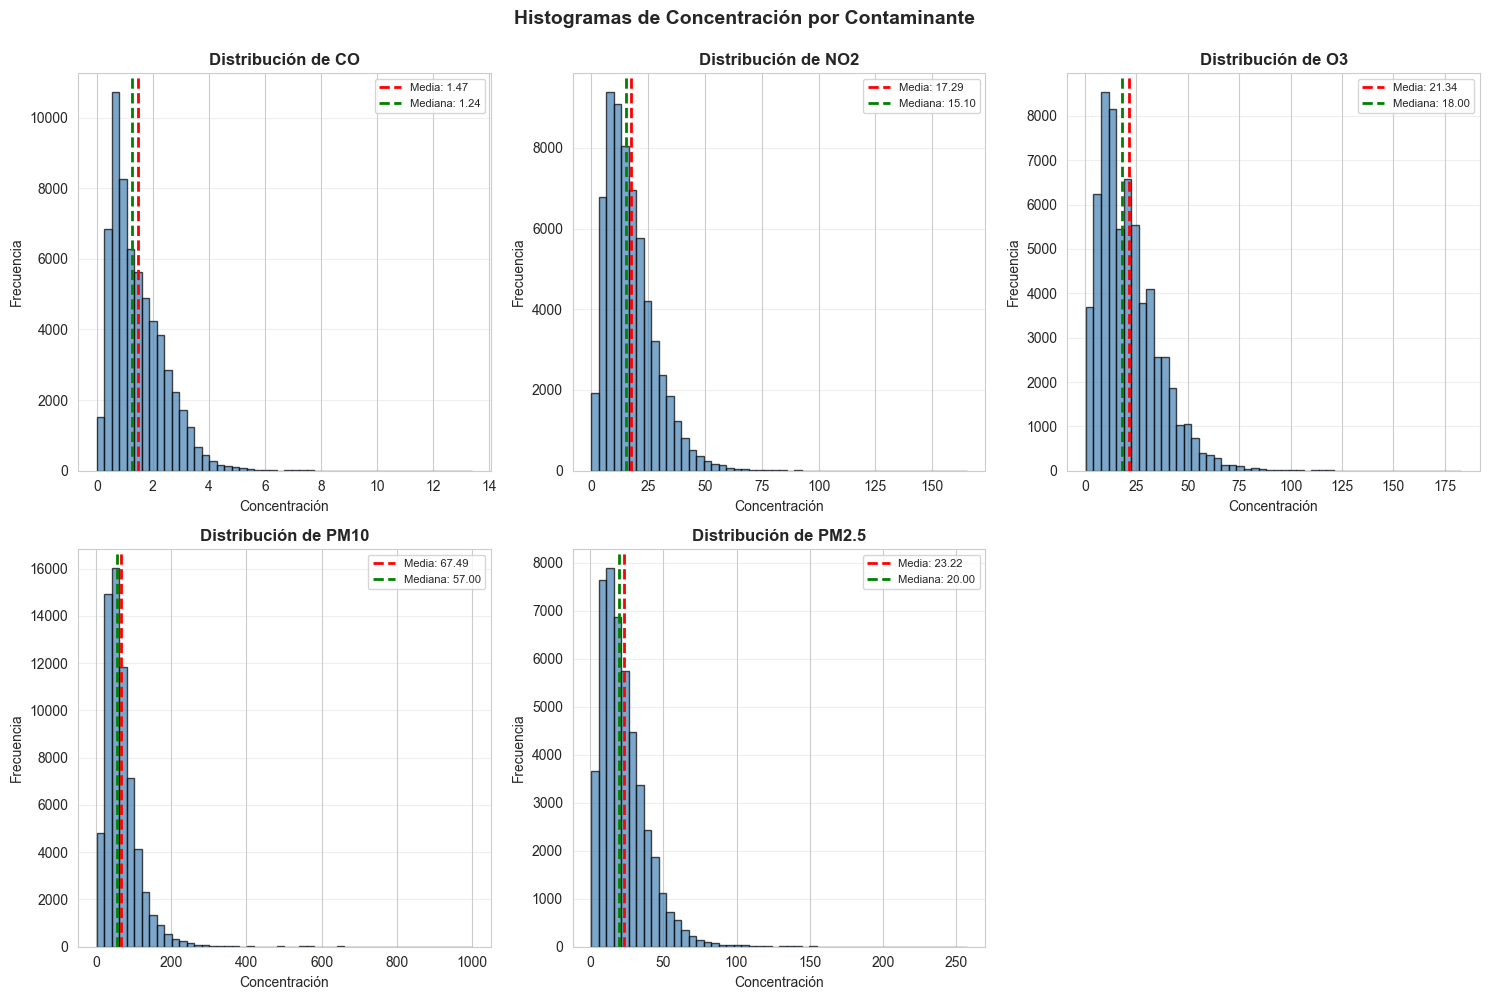

In [46]:
parametros = df['parametro'].unique()
n_params = len(parametros)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, param in enumerate(sorted(parametros)):
    data = df[df['parametro'] == param]['valor']
    
    axes[idx].hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribución de {param}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Concentración', fontsize=10)
    axes[idx].set_ylabel('Frecuencia', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Añadir estadísticas
    media = data.mean()
    mediana = data.median()
    axes[idx].axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
    axes[idx].axvline(mediana, color='green', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.2f}')
    axes[idx].legend(fontsize=8)

# Ocultar ejes extras si hay menos de 6 parámetros
for idx in range(n_params, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Histogramas de Concentración por Contaminante', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 12.2 Boxplot: Valor vs Franja Horaria

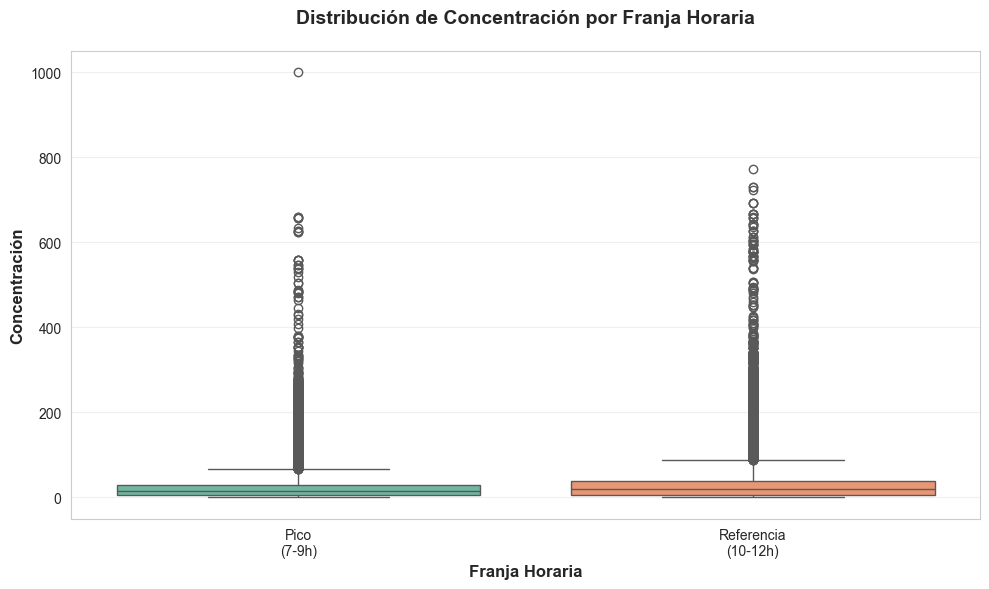

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=df, x='franja_horaria', y='valor', palette='Set2', ax=ax)

ax.set_title('Distribución de Concentración por Franja Horaria', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Franja Horaria', fontsize=12, fontweight='bold')
ax.set_ylabel('Concentración', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Etiquetas más descriptivas
etiquetas = ['Pico\n(7-9h)', 'Referencia\n(10-12h)']
ax.set_xticklabels(etiquetas)

plt.tight_layout()
plt.show()

### 12.3 Boxplot: Valor vs Clase

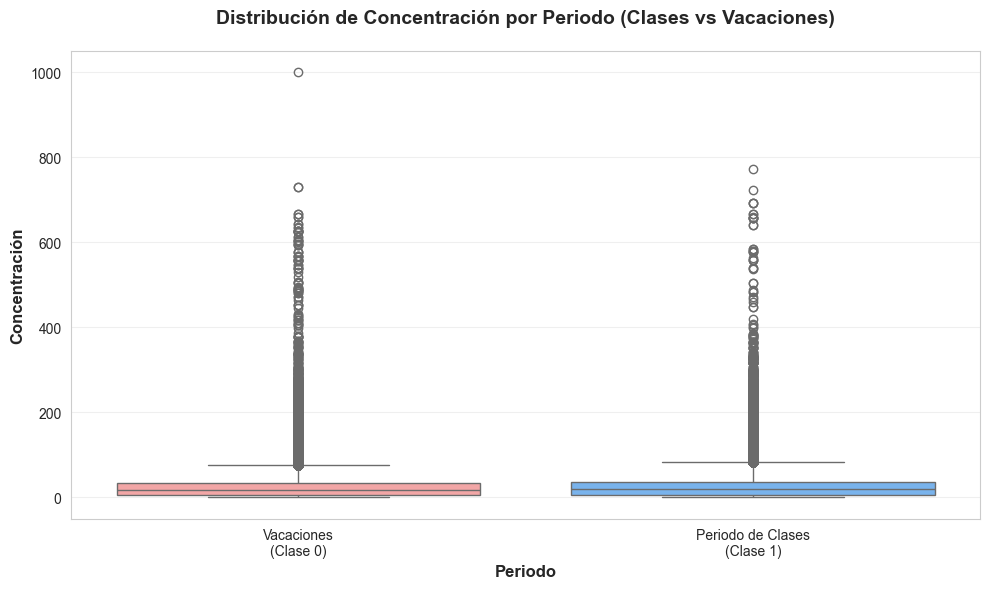

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=df, x='clase', y='valor', palette=['#ff9999', '#66b3ff'], ax=ax)

ax.set_title('Distribución de Concentración por Periodo (Clases vs Vacaciones)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Periodo', fontsize=12, fontweight='bold')
ax.set_ylabel('Concentración', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Etiquetas descriptivas
ax.set_xticklabels(['Vacaciones\n(Clase 0)', 'Periodo de Clases\n(Clase 1)'])

plt.tight_layout()
plt.show()

### 12.4 Boxplot: Valor por Estación

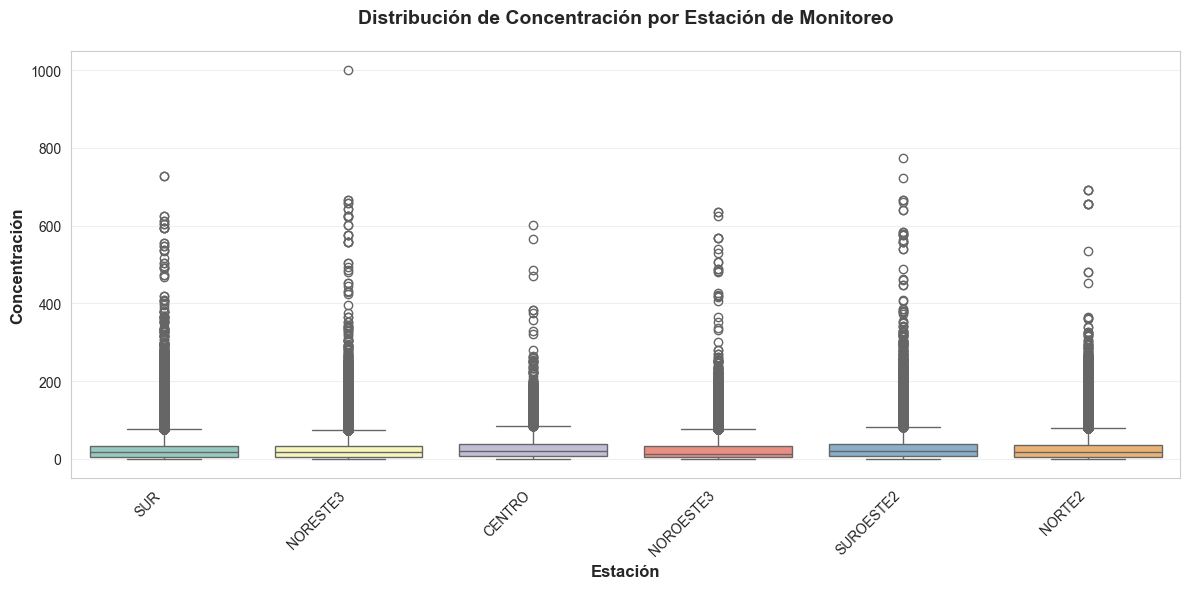

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=df, x='estacion', y='valor', palette='Set3', ax=ax)

ax.set_title('Distribución de Concentración por Estación de Monitoreo', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Estación', fontsize=12, fontweight='bold')
ax.set_ylabel('Concentración', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 12.5 Boxplot: Contaminante × Franja × Clase

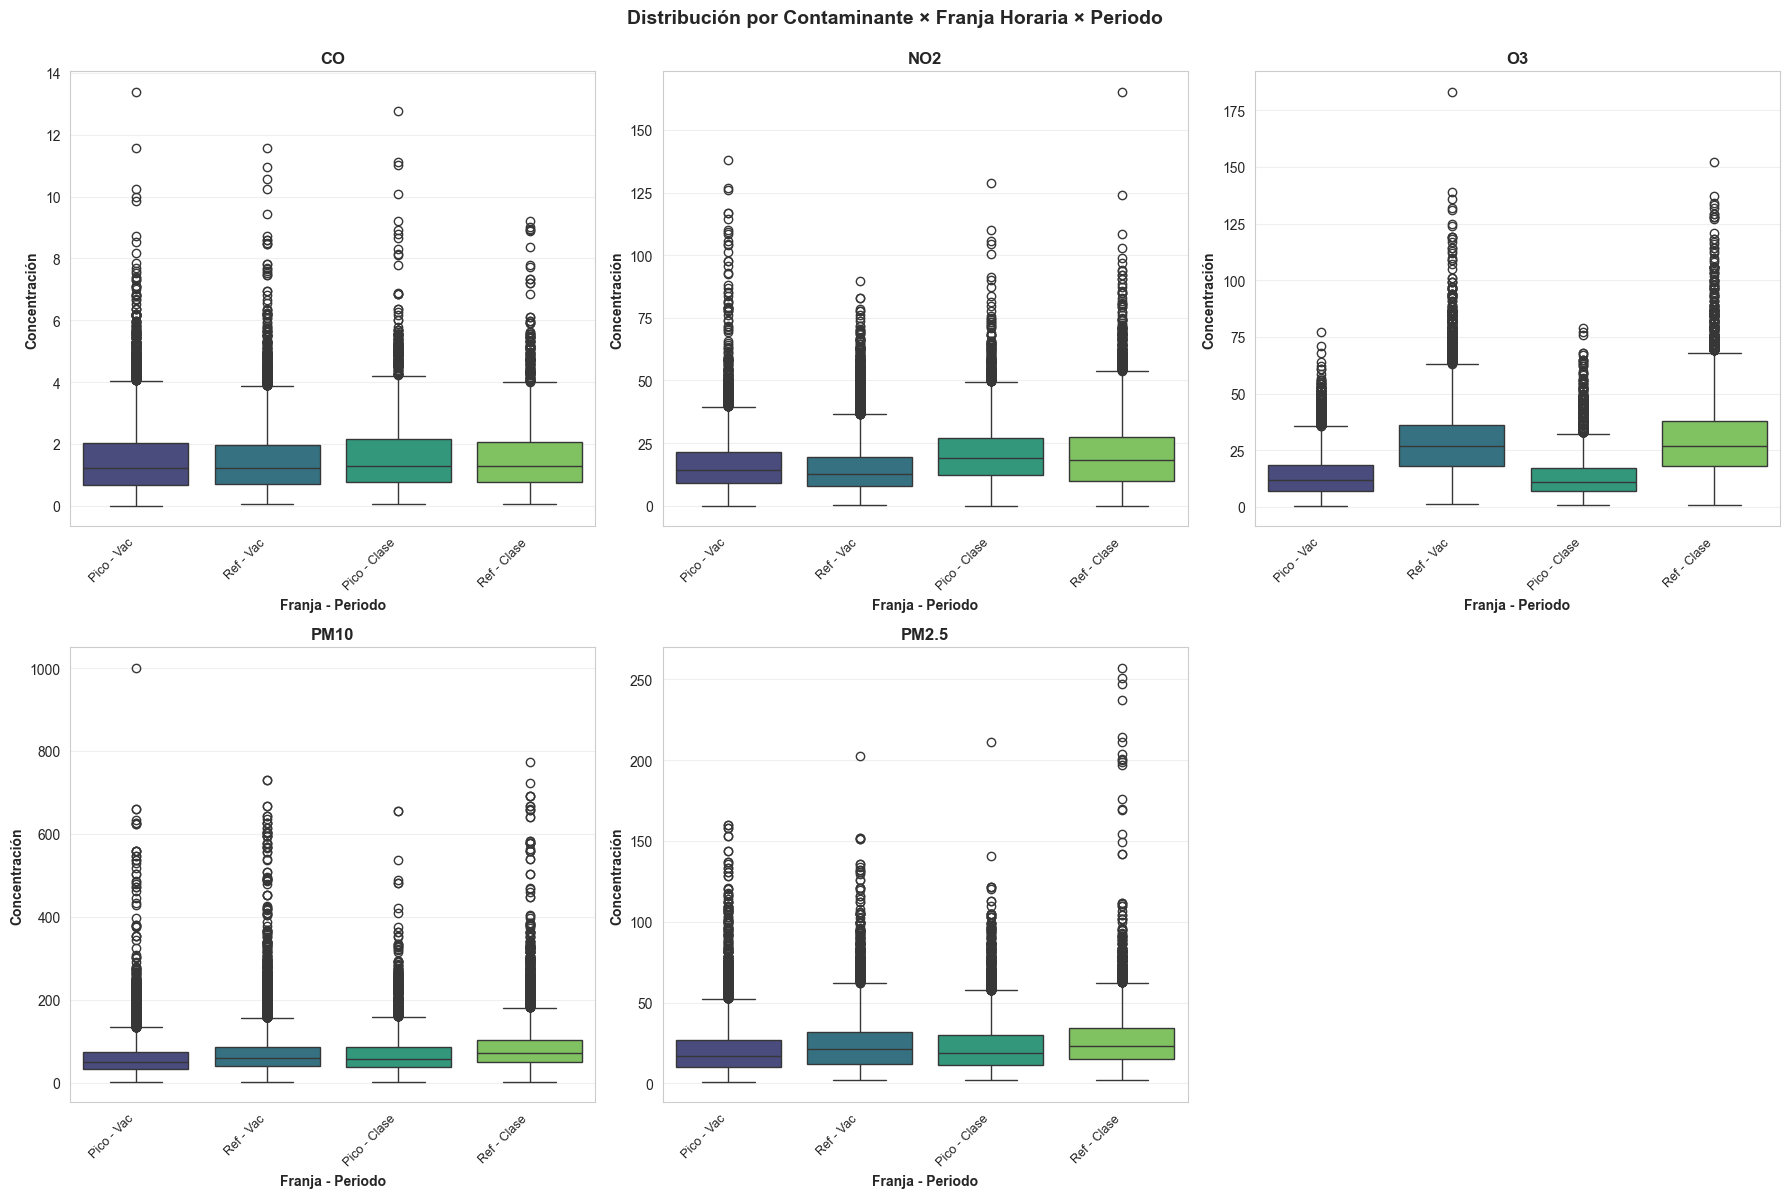

In [50]:
# Crear una columna combinada para mejor visualización
df['franja_clase'] = df['franja_horaria'].str.replace('pico_7_9', 'Pico').str.replace('ref_10_12', 'Ref') + \
                     ' - ' + df['clase'].map({0: 'Vac', 1: 'Clase'})

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

parametros_sorted = sorted(df['parametro'].unique())

for idx, param in enumerate(parametros_sorted):
    data_param = df[df['parametro'] == param]
    
    sns.boxplot(data=data_param, x='franja_clase', y='valor', 
                palette='viridis', ax=axes[idx])
    
    axes[idx].set_title(f'{param}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Franja - Periodo', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Concentración', fontsize=10, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Ajustar etiquetas del eje x
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right', fontsize=9)

# Ocultar ejes extras
for idx in range(len(parametros_sorted), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribución por Contaminante × Franja Horaria × Periodo', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Eliminar columna temporal
df.drop(columns=['franja_clase'], inplace=True)

### 12.6 Diagramas de barras

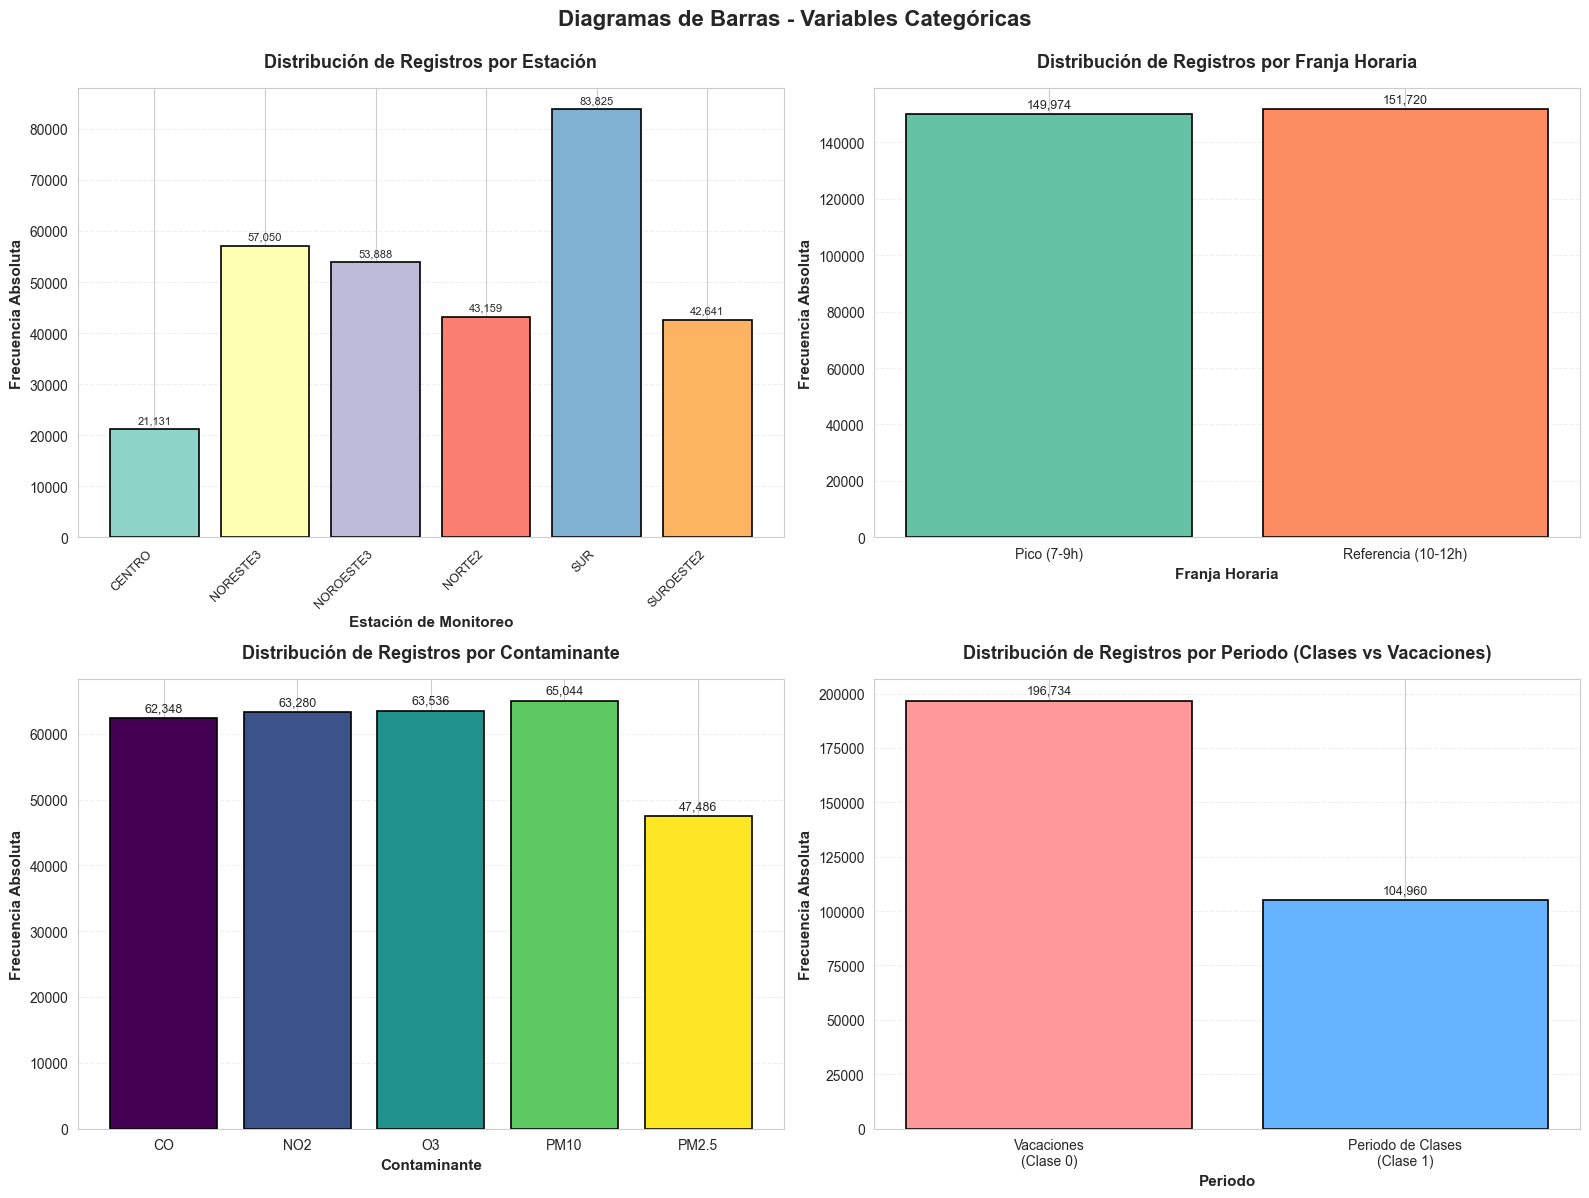

In [51]:
# Crear figura con subplots para diagramas de barras
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Frecuencia por Estación
ax1 = axes[0, 0]
freq_est = df['estacion'].value_counts().sort_index()
colors_est = plt.cm.Set3(range(len(freq_est)))
ax1.bar(range(len(freq_est)), freq_est.values, color=colors_est, edgecolor='black', linewidth=1.2)
ax1.set_xticks(range(len(freq_est)))
ax1.set_xticklabels(freq_est.index, rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Frecuencia Absoluta', fontsize=11, fontweight='bold')
ax1.set_xlabel('Estación de Monitoreo', fontsize=11, fontweight='bold')
ax1.set_title('Distribución de Registros por Estación', fontsize=13, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
# Añadir valores encima de las barras
for i, v in enumerate(freq_est.values):
    ax1.text(i, v + max(freq_est.values)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=8)

# 2. Frecuencia por Franja Horaria
ax2 = axes[0, 1]
freq_franja_plot = df['franja_horaria'].value_counts().sort_index()
colors_franja = ['#66c2a5', '#fc8d62']
ax2.bar(range(len(freq_franja_plot)), freq_franja_plot.values, color=colors_franja, edgecolor='black', linewidth=1.2)
ax2.set_xticks(range(len(freq_franja_plot)))
etiquetas_franja = ['Pico (7-9h)', 'Referencia (10-12h)']
ax2.set_xticklabels(etiquetas_franja, fontsize=10)
ax2.set_ylabel('Frecuencia Absoluta', fontsize=11, fontweight='bold')
ax2.set_xlabel('Franja Horaria', fontsize=11, fontweight='bold')
ax2.set_title('Distribución de Registros por Franja Horaria', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(freq_franja_plot.values):
    ax2.text(i, v + max(freq_franja_plot.values)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=9)

# 3. Frecuencia por Parámetro (Contaminante)
ax3 = axes[1, 0]
freq_param = df['parametro'].value_counts().sort_index()
colors_param = plt.cm.viridis(np.linspace(0, 1, len(freq_param)))
ax3.bar(range(len(freq_param)), freq_param.values, color=colors_param, edgecolor='black', linewidth=1.2)
ax3.set_xticks(range(len(freq_param)))
ax3.set_xticklabels(freq_param.index, fontsize=10)
ax3.set_ylabel('Frecuencia Absoluta', fontsize=11, fontweight='bold')
ax3.set_xlabel('Contaminante', fontsize=11, fontweight='bold')
ax3.set_title('Distribución de Registros por Contaminante', fontsize=13, fontweight='bold', pad=15)
ax3.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(freq_param.values):
    ax3.text(i, v + max(freq_param.values)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=9)

# 4. Frecuencia por Clase
ax4 = axes[1, 1]
freq_clase_plot = df['clase'].value_counts().sort_index()
colors_clase = ['#ff9999', '#66b3ff']
ax4.bar(range(len(freq_clase_plot)), freq_clase_plot.values, color=colors_clase, edgecolor='black', linewidth=1.2)
ax4.set_xticks(range(len(freq_clase_plot)))
etiquetas_clase = ['Vacaciones\n(Clase 0)', 'Periodo de Clases\n(Clase 1)']
ax4.set_xticklabels(etiquetas_clase, fontsize=10)
ax4.set_ylabel('Frecuencia Absoluta', fontsize=11, fontweight='bold')
ax4.set_xlabel('Periodo', fontsize=11, fontweight='bold')
ax4.set_title('Distribución de Registros por Periodo (Clases vs Vacaciones)', fontsize=13, fontweight='bold', pad=15)
ax4.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(freq_clase_plot.values):
    ax4.text(i, v + max(freq_clase_plot.values)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Diagramas de Barras - Variables Categóricas', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 12.6 Diagramas de pastel

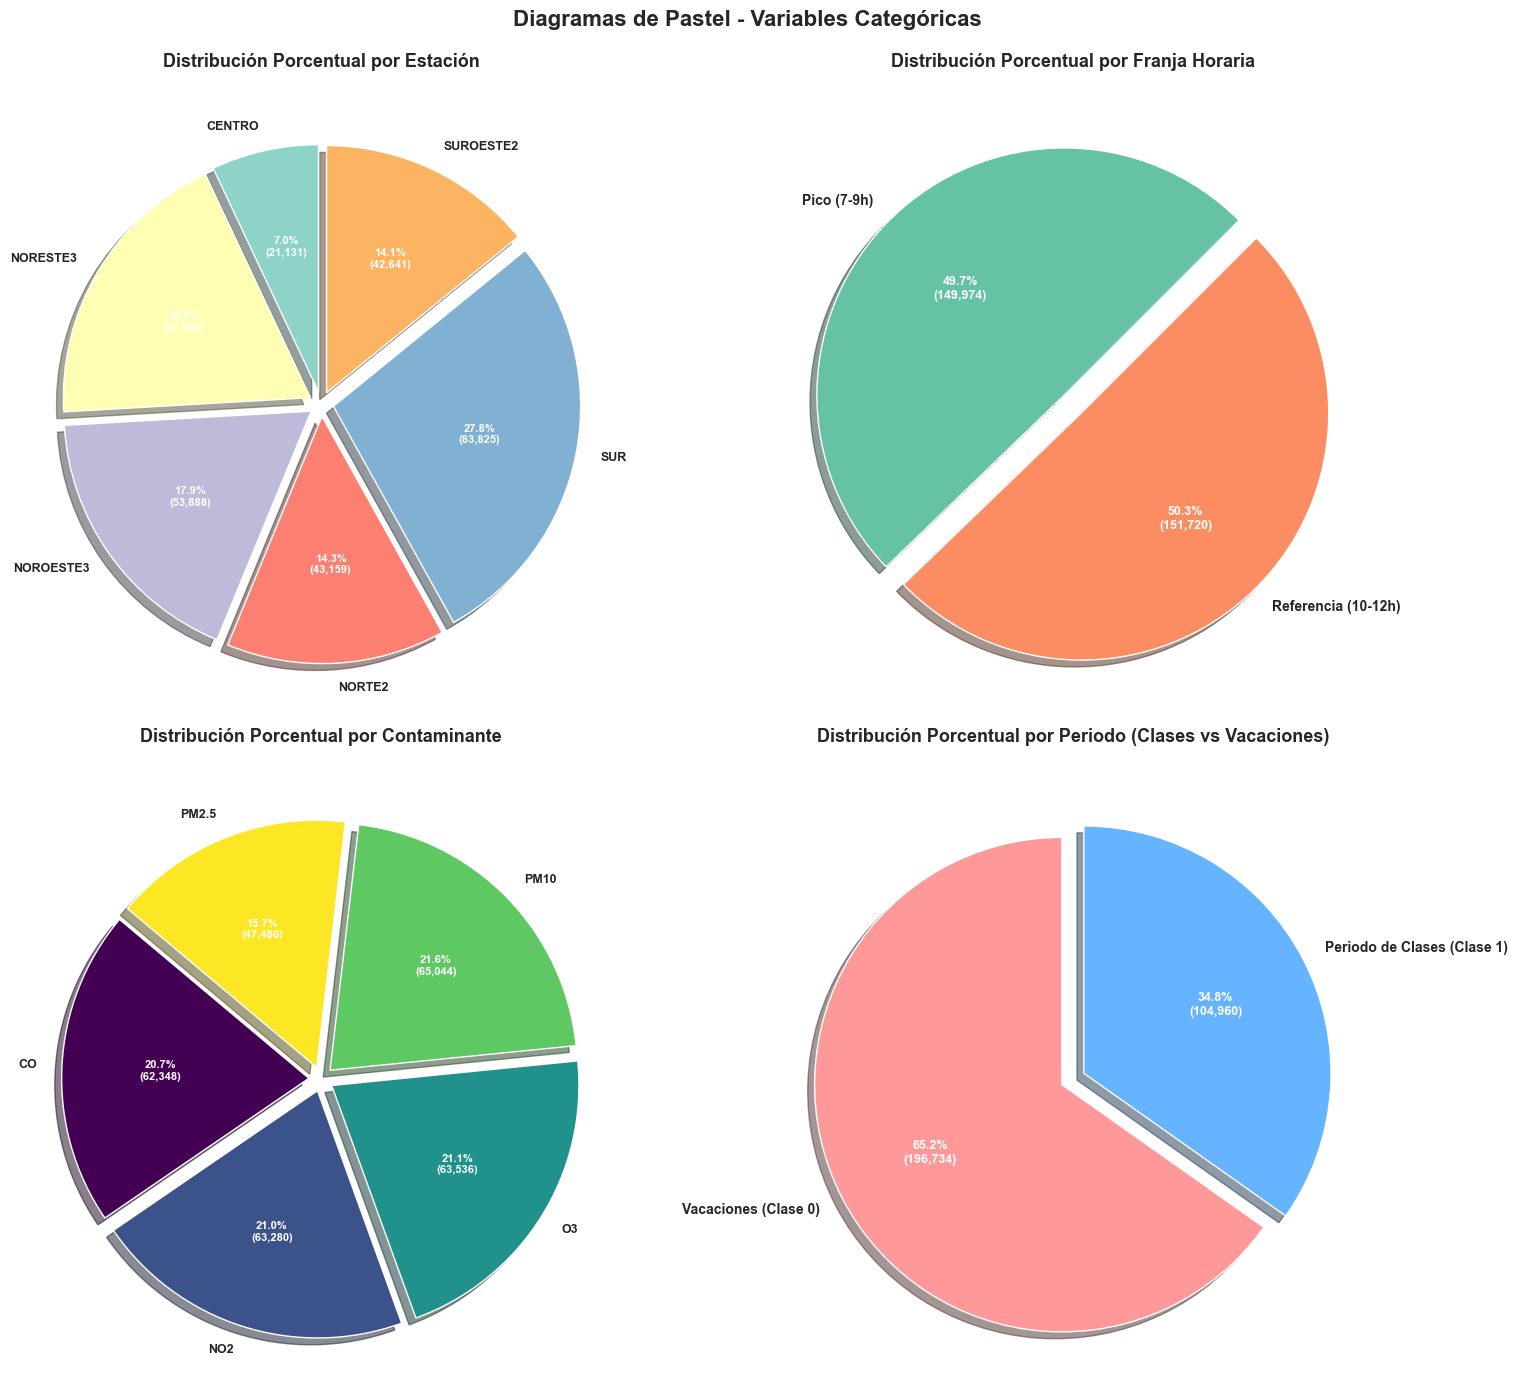

In [52]:
# Crear figura con subplots para diagramas de pastel
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Configuración de estilo para pasteles
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:,})' if pct > 2 else ''
    return my_format

# 1. Distribución por Estación
ax1 = axes[0, 0]
freq_est = df['estacion'].value_counts().sort_index()
colors_est = plt.cm.Set3(range(len(freq_est)))
wedges, texts, autotexts = ax1.pie(freq_est.values, 
                                     labels=freq_est.index, 
                                     autopct=autopct_format(freq_est.values),
                                     colors=colors_est,
                                     startangle=90,
                                     explode=[0.05]*len(freq_est),  # Separar ligeramente
                                     shadow=True,
                                     textprops={'fontsize': 9, 'fontweight': 'bold'})
ax1.set_title('Distribución Porcentual por Estación', fontsize=13, fontweight='bold', pad=20)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(8)

# 2. Distribución por Franja Horaria
ax2 = axes[0, 1]
freq_franja_plot = df['franja_horaria'].value_counts().sort_index()
colors_franja = ['#66c2a5', '#fc8d62']
etiquetas_franja = ['Pico (7-9h)', 'Referencia (10-12h)']
wedges, texts, autotexts = ax2.pie(freq_franja_plot.values, 
                                     labels=etiquetas_franja,
                                     autopct=autopct_format(freq_franja_plot.values),
                                     colors=colors_franja,
                                     startangle=45,
                                     explode=[0.05, 0.05],
                                     shadow=True,
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})
ax2.set_title('Distribución Porcentual por Franja Horaria', fontsize=13, fontweight='bold', pad=20)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)

# 3. Distribución por Contaminante
ax3 = axes[1, 0]
freq_param = df['parametro'].value_counts().sort_index()
colors_param = plt.cm.viridis(np.linspace(0, 1, len(freq_param)))
wedges, texts, autotexts = ax3.pie(freq_param.values, 
                                     labels=freq_param.index,
                                     autopct=autopct_format(freq_param.values),
                                     colors=colors_param,
                                     startangle=140,
                                     explode=[0.05]*len(freq_param),
                                     shadow=True,
                                     textprops={'fontsize': 9, 'fontweight': 'bold'})
ax3.set_title('Distribución Porcentual por Contaminante', fontsize=13, fontweight='bold', pad=20)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(8)

# 4. Distribución por Clase
ax4 = axes[1, 1]
freq_clase_plot = df['clase'].value_counts().sort_index()
colors_clase = ['#ff9999', '#66b3ff']
etiquetas_clase = ['Vacaciones (Clase 0)', 'Periodo de Clases (Clase 1)']
wedges, texts, autotexts = ax4.pie(freq_clase_plot.values, 
                                     labels=etiquetas_clase,
                                     autopct=autopct_format(freq_clase_plot.values),
                                     colors=colors_clase,
                                     startangle=90,
                                     explode=[0.05, 0.05],
                                     shadow=True,
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})
ax4.set_title('Distribución Porcentual por Periodo (Clases vs Vacaciones)', fontsize=13, fontweight='bold', pad=20)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)

plt.suptitle('Diagramas de Pastel - Variables Categóricas', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 13. Análisis de correlación entre contaminantes

### 13.1 Tabla pivot: Date × Contaminantes

In [53]:
# Crear tabla pivot: filas = date, columnas = parametro, valores = promedio de valor
pivot_contaminantes = df.pivot_table(
    index='date', 
    columns='parametro', 
    values='valor', 
    aggfunc='mean'
)

print("=" * 70)
print("TABLA PIVOT: FECHA × CONTAMINANTES")
print("=" * 70)
print(f"Forma de la tabla: {pivot_contaminantes.shape}")
print(f"Fechas únicas: {len(pivot_contaminantes)}")
print(f"Contaminantes: {list(pivot_contaminantes.columns)}")
print("=" * 70)
print("\nPrimeras 10 filas:")
print(pivot_contaminantes.head(10))
print("\nÚltimas 10 filas:")
print(pivot_contaminantes.tail(10))
print("=" * 70)

TABLA PIVOT: FECHA × CONTAMINANTES
Forma de la tabla: (3648, 5)
Fechas únicas: 3648
Contaminantes: ['CO', 'NO2', 'O3', 'PM10', 'PM2.5']

Primeras 10 filas:
parametro                  CO        NO2         O3        PM10      PM2.5
date                                                                      
2023-01-01 07:00:00  1.548600  28.420000   7.653333  101.000000  48.118182
2023-01-01 08:00:00  1.560667  25.660000   9.460000   80.466667  37.084167
2023-01-01 10:00:00  1.282933  17.880000  18.560000   77.533333  32.377273
2023-01-01 11:00:00  1.205067  16.153333  26.106667   66.000000  27.931000
2023-01-02 07:00:00  1.252667  23.613333   6.606667   66.400000  24.298182
2023-01-02 08:00:00  1.369533  25.666667   7.020000   76.800000  22.497273
2023-01-02 10:00:00  1.658800  28.793333  10.213333  102.400000  27.613636
2023-01-02 11:00:00  1.527067  28.813333  16.260000  104.866667  28.759167
2023-01-03 07:00:00  0.936867  17.740000  13.960000   75.142857   8.646000
2023-01-03 08:00:00

### 13.2 Matriz de correlación entre contaminantes

In [54]:
# Calcular matriz de correlación
contaminantes_interes = ['CO', 'NO2', 'PM10', 'PM2.5', 'O3']
correlacion = pivot_contaminantes[contaminantes_interes].corr()

print("=" * 70)
print("MATRIZ DE CORRELACIÓN ENTRE CONTAMINANTES")
print("=" * 70)
print(correlacion.round(3))
print("=" * 70)

# Estadísticas de la correlación
print("\nEstadísticas de correlación:")
print(f"  • Correlación promedio: {correlacion.values[np.triu_indices_from(correlacion.values, k=1)].mean():.3f}")
print(f"  • Correlación máxima: {correlacion.values[np.triu_indices_from(correlacion.values, k=1)].max():.3f}")
print(f"  • Correlación mínima: {correlacion.values[np.triu_indices_from(correlacion.values, k=1)].min():.3f}")

# Pares con mayor correlación
print("\nPares con mayor correlación:")
corr_pairs = []
for i in range(len(correlacion.columns)):
    for j in range(i+1, len(correlacion.columns)):
        corr_pairs.append((correlacion.columns[i], correlacion.columns[j], correlacion.iloc[i, j]))
corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)
for par1, par2, corr_val in corr_pairs_sorted[:5]:
    print(f"  • {par1} - {par2}: {corr_val:.3f}")

MATRIZ DE CORRELACIÓN ENTRE CONTAMINANTES
parametro     CO    NO2   PM10  PM2.5     O3
parametro                                   
CO         1.000  0.444  0.416  0.442 -0.144
NO2        0.444  1.000  0.571  0.427 -0.238
PM10       0.416  0.571  1.000  0.716  0.074
PM2.5      0.442  0.427  0.716  1.000  0.092
O3        -0.144 -0.238  0.074  0.092  1.000

Estadísticas de correlación:
  • Correlación promedio: 0.280
  • Correlación máxima: 0.716
  • Correlación mínima: -0.238

Pares con mayor correlación:
  • PM10 - PM2.5: 0.716
  • NO2 - PM10: 0.571
  • CO - NO2: 0.444
  • CO - PM2.5: 0.442
  • NO2 - PM2.5: 0.427


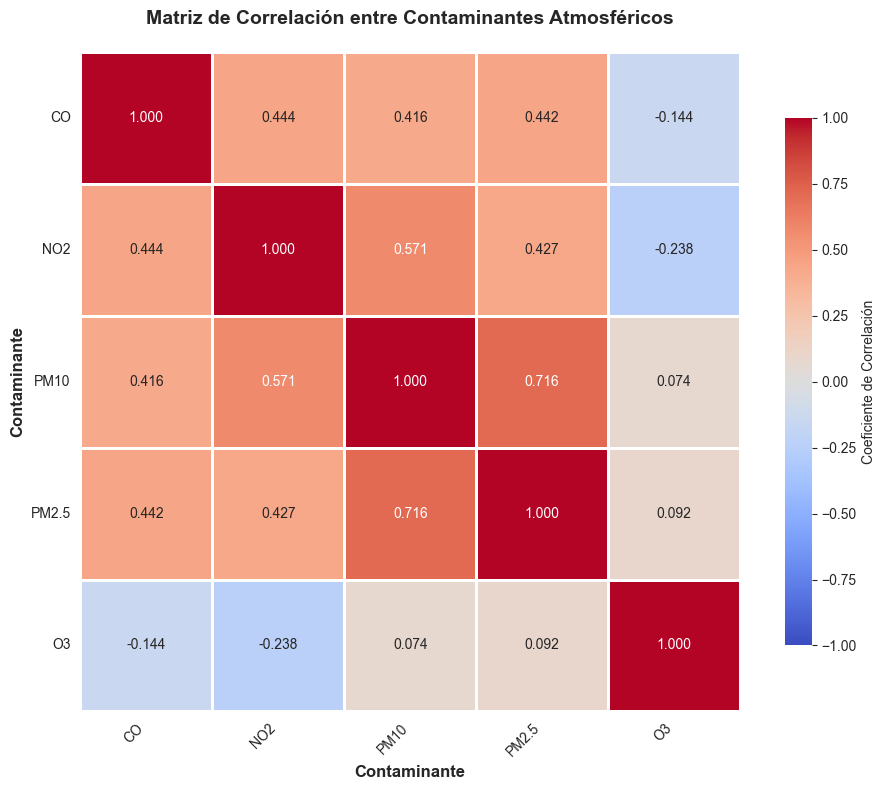

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))

# Crear heatmap con anotaciones
sns.heatmap(correlacion, 
            annot=True,  # Mostrar valores
            fmt='.3f',   # Formato con 3 decimales
            cmap='coolwarm',  # Esquema de colores
            center=0,    # Centrar en 0
            square=True,  # Celdas cuadradas
            linewidths=1,  # Líneas entre celdas
            cbar_kws={'label': 'Coeficiente de Correlación', 'shrink': 0.8},
            vmin=-1, 
            vmax=1,
            ax=ax)

ax.set_title('Matriz de Correlación entre Contaminantes Atmosféricos', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Contaminante', fontsize=12, fontweight='bold')
ax.set_ylabel('Contaminante', fontsize=12, fontweight='bold')

# Rotar etiquetas para mejor legibilidad
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

## 14. Correlación entre franjas horarias (7-9h vs 10-12h)

CORRELACIÓN: FRANJA 7-9h vs 10-12h
CO        r = 0.568
NO2       r = 0.532
O3        r = 0.349
PM10      r = 0.713
PM2.5     r = 0.491

Correlación general: 0.810
✓ FUERTE: 7-9h predicen bien 10-12h


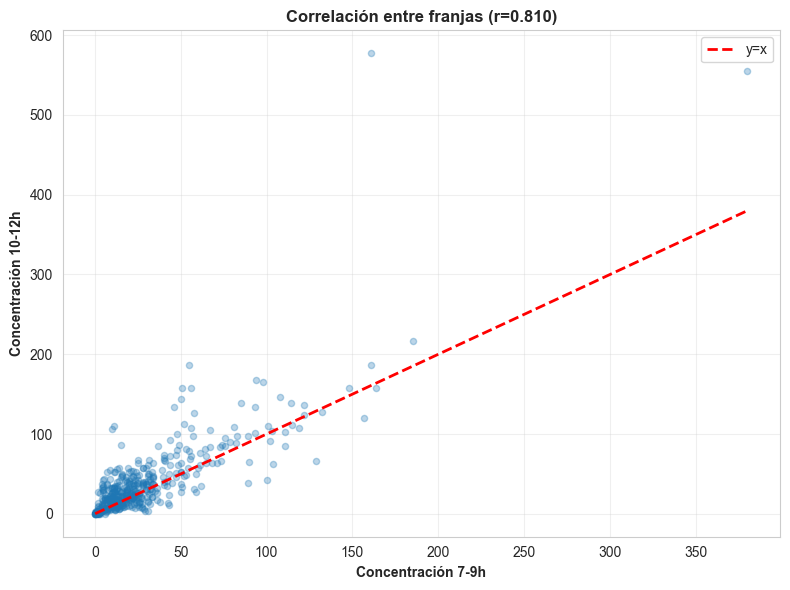

In [56]:
# Muestra aleatoria para acelerar
df_sample = df.sample(n=min(10000, len(df)), random_state=42).copy()
df_sample['fecha_dia'] = df_sample['date'].dt.date

# Agrupar por franja
pico = df_sample[df_sample['franja_horaria'] == 'pico_7_9'].groupby(['fecha_dia', 'estacion', 'parametro'])['valor'].mean()
ref = df_sample[df_sample['franja_horaria'] == 'ref_10_12'].groupby(['fecha_dia', 'estacion', 'parametro'])['valor'].mean()

# Unir
datos = pd.DataFrame({'pico': pico, 'ref': ref}).dropna()

# Correlación por contaminante
print("=" * 60)
print("CORRELACIÓN: FRANJA 7-9h vs 10-12h")
print("=" * 60)

for param in df['parametro'].unique():
    mask = datos.index.get_level_values('parametro') == param
    if mask.sum() > 0:
        r = datos[mask]['pico'].corr(datos[mask]['ref'])
        print(f"{param:8s}  r = {r:.3f}")

# Correlación general
r_total = datos['pico'].corr(datos['ref'])
print("\n" + "=" * 60)
print(f"Correlación general: {r_total:.3f}")
if r_total >= 0.7:
    print("✓ FUERTE: 7-9h predicen bien 10-12h")
elif r_total >= 0.3:
    print("≈ MODERADA: Relación con variabilidad")
else:
    print("✗ DÉBIL: Franjas independientes")
print("=" * 60)

# Gráfico scatter
fig, ax = plt.subplots(figsize=(8, 6))
sample_plot = datos.sample(n=min(500, len(datos)), random_state=42)
ax.scatter(sample_plot['pico'], sample_plot['ref'], alpha=0.3, s=20)
ax.plot([datos['pico'].min(), datos['pico'].max()], 
        [datos['pico'].min(), datos['pico'].max()], 
        'r--', lw=2, label='y=x')
ax.set_xlabel('Concentración 7-9h', fontweight='bold')
ax.set_ylabel('Concentración 10-12h', fontweight='bold')
ax.set_title(f'Correlación entre franjas (r={r_total:.3f})', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 14.1 Prueba de LJUNG-BOX

In [57]:
from scipy import stats as scipy_stats
from statsmodels.stats.diagnostic import acorr_ljungbox

print("=" * 80)
print("PRUEBA DE LJUNG-BOX PARA AUTOCORRELACIÓN")
print("=" * 80)
print("\nObjetivo: Detectar autocorrelación en la serie temporal de concentraciones")
print("H0: No existe autocorrelación significativa en la serie")
print("H1: Existe autocorrelación significativa en la serie")
print("=" * 80)

# Crear serie temporal agregada por día (promedio de todas las estaciones y contaminantes)
serie_diaria_pico = df_pico.groupby('date')['valor'].mean().sort_index()

print(f"\nSerie temporal analizada:")
print(f"  • Periodo: {serie_diaria_pico.index.min()} a {serie_diaria_pico.index.max()}")
print(f"  • Observaciones: {len(serie_diaria_pico):,}")
print(f"  • Frecuencia: Diaria")
print(f"  • Promedio: {serie_diaria_pico.mean():.2f}")
print(f"  • Desv. Estándar: {serie_diaria_pico.std():.2f}")

# Aplicar prueba de Ljung-Box con diferentes rezagos
lags = [1, 5, 10, 15, 20, 30]
print("\n" + "=" * 80)
print("RESULTADOS DE LA PRUEBA DE LJUNG-BOX")
print("=" * 80)

resultados_ljungbox = []

for lag in lags:
    if lag < len(serie_diaria_pico):
        lb_result = acorr_ljungbox(serie_diaria_pico, lags=[lag], return_df=True)
        lb_stat = lb_result['lb_stat'].iloc[0]
        p_value = lb_result['lb_pvalue'].iloc[0]
        
        resultado = {
            'Rezago': lag,
            'Estadístico LB': round(lb_stat, 4),
            'p-valor': round(p_value, 4),
            'Decisión (α=0.05)': 'Rechazar H0' if p_value < 0.05 else 'No rechazar H0',
            'Interpretación': 'Autocorrelación significativa' if p_value < 0.05 else 'No hay autocorrelación significativa'
        }
        resultados_ljungbox.append(resultado)

# Crear DataFrame con resultados
df_ljungbox = pd.DataFrame(resultados_ljungbox)
print(df_ljungbox.to_string(index=False))
print("=" * 80)

# Interpretación general
autocorr_count = sum(1 for r in resultados_ljungbox if r['p-valor'] < 0.05)
print(f"\n INTERPRETACIÓN GENERAL:")
print(f"  • Rezagos con autocorrelación significativa: {autocorr_count}/{len(resultados_ljungbox)}")

if autocorr_count >= len(resultados_ljungbox) * 0.7:
    print("  • CONCLUSIÓN: Fuerte evidencia de autocorrelación en la serie temporal")
    print("  • Las concentraciones de contaminantes de un día están relacionadas con días anteriores")
elif autocorr_count >= len(resultados_ljungbox) * 0.3:
    print("  • CONCLUSIÓN: Evidencia moderada de autocorrelación en la serie temporal")
    print("  • Algunas concentraciones muestran dependencia temporal")
else:
    print("  • CONCLUSIÓN: Poca o ninguna evidencia de autocorrelación en la serie temporal")
    print("  • Las concentraciones diarias son relativamente independientes")


PRUEBA DE LJUNG-BOX PARA AUTOCORRELACIÓN

Objetivo: Detectar autocorrelación en la serie temporal de concentraciones
H0: No existe autocorrelación significativa en la serie
H1: Existe autocorrelación significativa en la serie

Serie temporal analizada:
  • Periodo: 2023-01-01 07:00:00 a 2025-06-30 08:00:00
  • Observaciones: 1,824
  • Frecuencia: Diaria
  • Promedio: 23.00
  • Desv. Estándar: 9.13

RESULTADOS DE LA PRUEBA DE LJUNG-BOX
 Rezago  Estadístico LB  p-valor Decisión (α=0.05)                Interpretación
      1        970.6379      0.0       Rechazar H0 Autocorrelación significativa
      5       2063.8682      0.0       Rechazar H0 Autocorrelación significativa
     10       2365.7398      0.0       Rechazar H0 Autocorrelación significativa
     15       2739.6864      0.0       Rechazar H0 Autocorrelación significativa
     20       2909.0203      0.0       Rechazar H0 Autocorrelación significativa
     30       3282.5493      0.0       Rechazar H0 Autocorrelación signific

## 15. Análisis exploratorio  (7-9h)

### 15.1 Filtrar solo datos de franja  (7-9h)

In [58]:
# Filtrar solo la franja horaria de pico (7-9h)
df_pico = df[df['franja_horaria'] == 'pico_7_9'].copy()

print("=" * 80)
print("DATASET FILTRADO - SOLO FRANJA PICO (7-9h)")
print("=" * 80)
print(f"Total de registros originales:       {len(df):>15,}")
print(f"Registros en franja pico (7-9h):     {len(df_pico):>15,}")
print(f"Porcentaje del dataset original:     {(len(df_pico)/len(df)*100):>15.2f}%")
print("=" * 80)
print(f"\nColumnas: {df_pico.columns.tolist()}")
print(f"Rango de fechas: {df_pico['date'].min()} a {df_pico['date'].max()}")
print(f"Estaciones: {sorted(df_pico['estacion'].unique())}")
print(f"Contaminantes: {sorted(df_pico['parametro'].unique())}")
print("=" * 80)

DATASET FILTRADO - SOLO FRANJA PICO (7-9h)
Total de registros originales:               301,694
Registros en franja pico (7-9h):             149,974
Porcentaje del dataset original:               49.71%

Columnas: ['date', 'anio', 'mes', 'dia', 'hora', 'estacion', 'franja_horaria', 'parametro', 'valor', 'clase']
Rango de fechas: 2023-01-01 07:00:00 a 2025-06-30 08:00:00
Estaciones: ['CENTRO', 'NORESTE3', 'NOROESTE3', 'NORTE2', 'SUR', 'SUROESTE2']
Contaminantes: ['CO', 'NO2', 'O3', 'PM10', 'PM2.5']


### 15.2 Estadísticas descriptivas generales 

In [59]:
stats_pico_general = calcular_estadisticas_completas(df_pico['valor'])
stats_pico_general_df = pd.DataFrame(stats_pico_general, columns=['Estadístico - Pico 7-9h'])

print("=" * 70)
print("ESTADÍSTICAS DESCRIPTIVAS GENERALES - SOLO FRANJA PICO (7-9h)")
print("=" * 70)
print(stats_pico_general_df.to_string())
print("=" * 70)

ESTADÍSTICAS DESCRIPTIVAS GENERALES - SOLO FRANJA PICO (7-9h)
          Estadístico - Pico 7-9h
media                   23.474426
mediana                 14.100000
moda                     6.000000
minimo                   0.000000
maximo                1000.000000
rango                 1000.000000
varianza               906.327925
desv_std                30.105281
Q1                       4.900000
Q2                      14.100000
Q3                      29.940000
IQR                     25.040000
n                   149974.000000


### 15.3 Estadísticas por estación 

In [60]:
stats_pico_estacion = df_pico.groupby('estacion')['valor'].apply(calcular_estadisticas_completas).unstack()

print("=" * 90)
print("ESTADÍSTICAS POR ESTACIÓN - SOLO FRANJA PICO (7-9h)")
print("=" * 90)
print(stats_pico_estacion.to_string())
print("=" * 90)

ESTADÍSTICAS POR ESTACIÓN - SOLO FRANJA PICO (7-9h)
               media  mediana  moda  minimo  maximo    rango    varianza   desv_std      Q1    Q2     Q3      IQR        n
estacion                                                                                                                  
CENTRO     24.895934     17.0  10.0    0.09   486.0   485.91  741.602620  27.232382  6.0000  17.0  33.35  27.3500  10488.0
NORESTE3   23.373405     14.7  11.0    0.00  1000.0  1000.00  990.814078  31.477199  5.7525  14.7  29.00  23.2475  28310.0
NOROESTE3  21.574486     11.5   6.0    0.00   634.0   634.00  782.249834  27.968730  3.3000  11.5  27.00  23.7000  26696.0
NORTE2     24.733400     15.0  12.0    0.05   656.0   655.95  996.306526  31.564324  5.0000  15.0  31.00  26.0000  21400.0
SUR        22.867995     14.0  13.0    0.00   547.0   547.00  882.731724  29.710801  4.7000  14.0  29.00  24.3000  41865.0
SUROESTE2  25.224042     16.0   8.0    0.05   488.0   487.95  976.226342  31.244621  5.

### 15.4 Estadísticas por contaminante

In [61]:
stats_pico_parametro = df_pico.groupby('parametro')['valor'].apply(calcular_estadisticas_completas).unstack()

print("=" * 90)
print("ESTADÍSTICAS POR CONTAMINANTE - SOLO FRANJA PICO (7-9h)")
print("=" * 90)
print(stats_pico_parametro.to_string())
print("=" * 90)

ESTADÍSTICAS POR CONTAMINANTE - SOLO FRANJA PICO (7-9h)
               media  mediana   moda  minimo   maximo   rango     varianza   desv_std      Q1     Q2     Q3     IQR        n
parametro                                                                                                                   
CO          1.481237     1.24   0.72     0.0    13.38   13.38     0.994017   0.997004   0.719   1.24   2.07   1.351  31166.0
NO2        17.740910    15.90  11.00     0.0   137.80  137.80   110.874724  10.529707  10.000  15.90  23.45  13.450  31611.0
O3         13.559838    12.00   6.00     0.5    79.00   78.50    80.423017   8.967888   7.000  12.00  18.00  11.000  31037.0
PM10       61.057875    51.00  34.00     2.0  1000.00  998.00  1813.959081  42.590599  34.000  51.00  77.00  43.000  32544.0
PM2.5      21.411638    18.00  13.00     1.0   211.06  210.06   238.274115  15.436130  10.915  18.00  28.00  17.085  23616.0


### 15.5 Estadísticas por clase (periodo escolar)

In [62]:
stats_pico_clase = df_pico.groupby('clase')['valor'].apply(calcular_estadisticas_completas).unstack()

print("=" * 90)
print("ESTADÍSTICAS POR CLASE - SOLO FRANJA PICO (7-9h)")
print("=" * 90)
print("Clase 0 = Periodo fuera de clases / Vacaciones")
print("Clase 1 = Periodo de clases")
print("=" * 90)
print(stats_pico_clase.to_string())
print("=" * 90)

ESTADÍSTICAS POR CLASE - SOLO FRANJA PICO (7-9h)
Clase 0 = Periodo fuera de clases / Vacaciones
Clase 1 = Periodo de clases
           media  mediana  moda  minimo  maximo   rango     varianza   desv_std   Q1    Q2    Q3   IQR        n
clase                                                                                                          
0      22.482999     13.9   6.0     0.0  1000.0  1000.0   838.969757  28.964975  4.5  13.9  28.5  24.0  97730.0
1      25.329035     16.0   8.0     0.0   656.0   656.0  1027.071260  32.047953  5.0  16.0  32.0  27.0  52244.0


### 15.6 Estadísticas por estación × clase

In [63]:
stats_pico_est_clase = df_pico.groupby(['estacion', 'clase'])['valor'].apply(calcular_estadisticas_completas).unstack()

print("=" * 100)
print("ESTADÍSTICAS POR ESTACIÓN × CLASE - SOLO FRANJA PICO (7-9h)")
print("=" * 100)
print(stats_pico_est_clase.to_string())
print("=" * 100)

ESTADÍSTICAS POR ESTACIÓN × CLASE - SOLO FRANJA PICO (7-9h)
                     media  mediana  moda  minimo  maximo    rango     varianza   desv_std      Q1      Q2      Q3      IQR        n
estacion  clase                                                                                                                     
CENTRO    0      23.740208   16.000  10.0    0.11   486.0   485.89   657.930893  25.650164  6.0000  16.000  32.000  26.0000   5612.0
          1      26.226110   18.015  10.0    0.09   375.0   374.91   834.751394  28.892065  6.0000  18.015  34.185  28.1850   4876.0
NORESTE3  0      23.373405   14.700  11.0    0.00  1000.0  1000.00   990.814078  31.477199  5.7525  14.700  29.000  23.2475  28310.0
NOROESTE3 0      21.574486   11.500   6.0    0.00   634.0   634.00   782.249834  27.968730  3.3000  11.500  27.000  23.7000  26696.0
NORTE2    0      22.083122   14.000  12.0    0.05   266.0   265.95   693.883478  26.341668  5.0000  14.000  28.900  23.9000   8293.0
         

### 15.7 Visualizaciones - Histogramas por contaminante

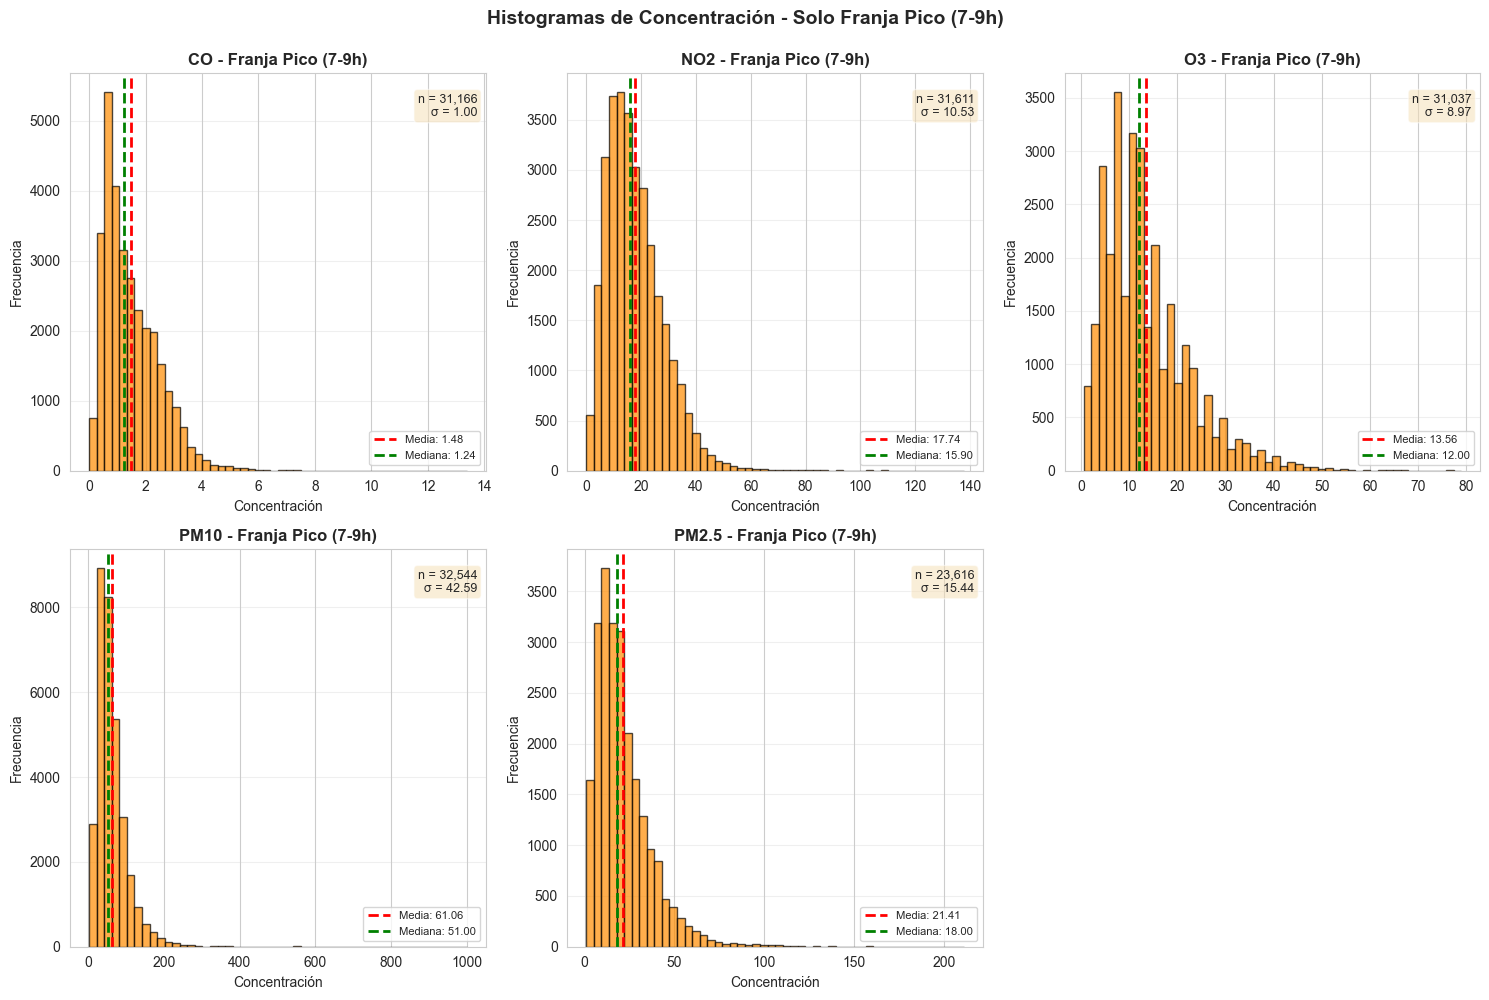

In [64]:
parametros_pico = df_pico['parametro'].unique()
n_params_pico = len(parametros_pico)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, param in enumerate(sorted(parametros_pico)):
    data = df_pico[df_pico['parametro'] == param]['valor']
    
    axes[idx].hist(data, bins=50, color='darkorange', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{param} - Franja Pico (7-9h)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Concentración', fontsize=10)
    axes[idx].set_ylabel('Frecuencia', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Estadísticas
    media = data.mean()
    mediana = data.median()
    desv = data.std()
    axes[idx].axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
    axes[idx].axvline(mediana, color='green', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.2f}')
    axes[idx].legend(fontsize=8)
    
    # Añadir n y desv std
    axes[idx].text(0.98, 0.95, f'n = {len(data):,}\nσ = {desv:.2f}', 
                   transform=axes[idx].transAxes, 
                   fontsize=9, 
                   verticalalignment='top',
                   horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Ocultar ejes extras
for idx in range(n_params_pico, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Histogramas de Concentración - Solo Franja Pico (7-9h)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 15.8 Boxplot por estación

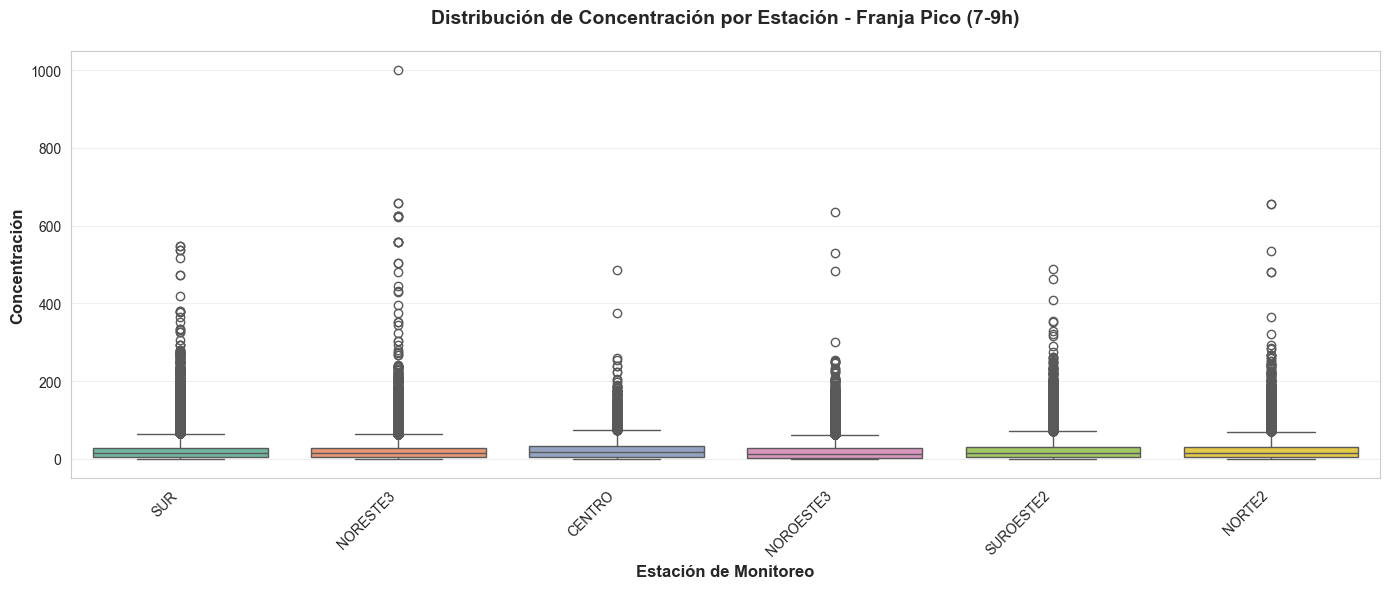

In [65]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(data=df_pico, x='estacion', y='valor', palette='Set2', ax=ax)

ax.set_title('Distribución de Concentración por Estación - Franja Pico (7-9h)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Estación de Monitoreo', fontsize=12, fontweight='bold')
ax.set_ylabel('Concentración', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 15.9 Boxplot por contaminante

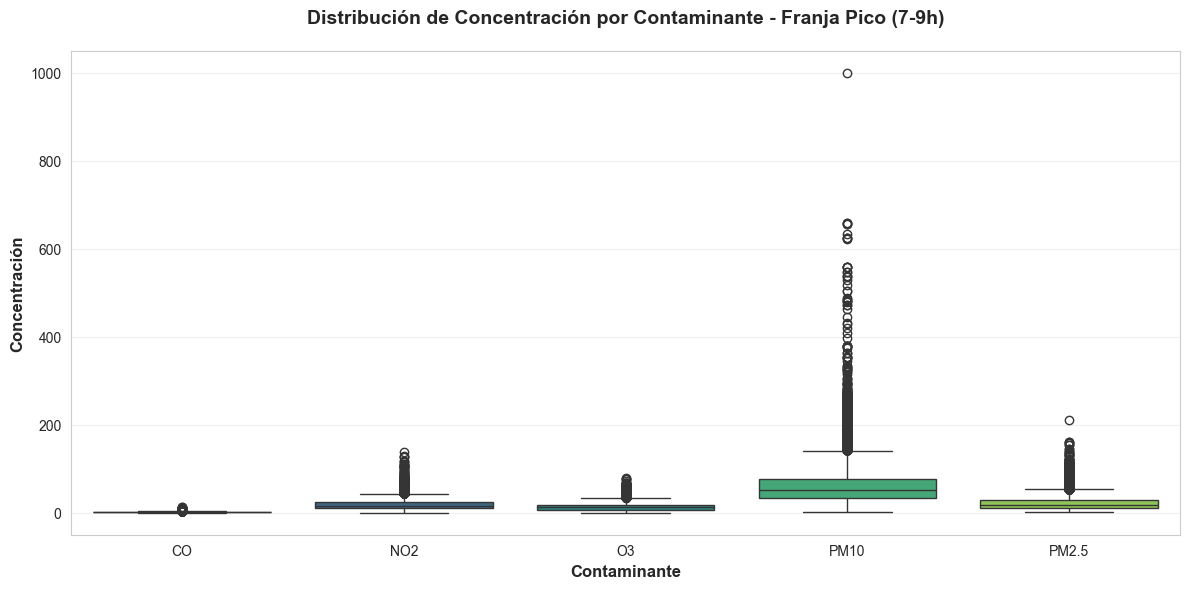

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=df_pico, x='parametro', y='valor', palette='viridis', ax=ax)

ax.set_title('Distribución de Concentración por Contaminante - Franja Pico (7-9h)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Contaminante', fontsize=12, fontweight='bold')
ax.set_ylabel('Concentración', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 15.10 Boxplot por clase (periodo escolar)

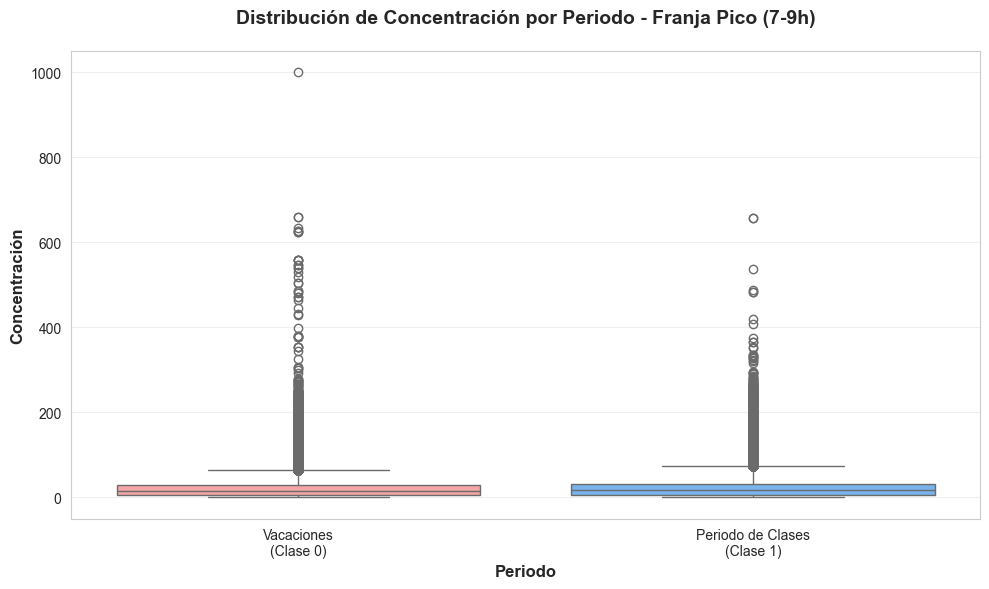

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=df_pico, x='clase', y='valor', palette=['#ff9999', '#66b3ff'], ax=ax)

ax.set_title('Distribución de Concentración por Periodo - Franja Pico (7-9h)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Periodo', fontsize=12, fontweight='bold')
ax.set_ylabel('Concentración', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

ax.set_xticklabels(['Vacaciones\n(Clase 0)', 'Periodo de Clases\n(Clase 1)'])

plt.tight_layout()
plt.show()

### 15.11 Boxplot: Contaminante × Clase

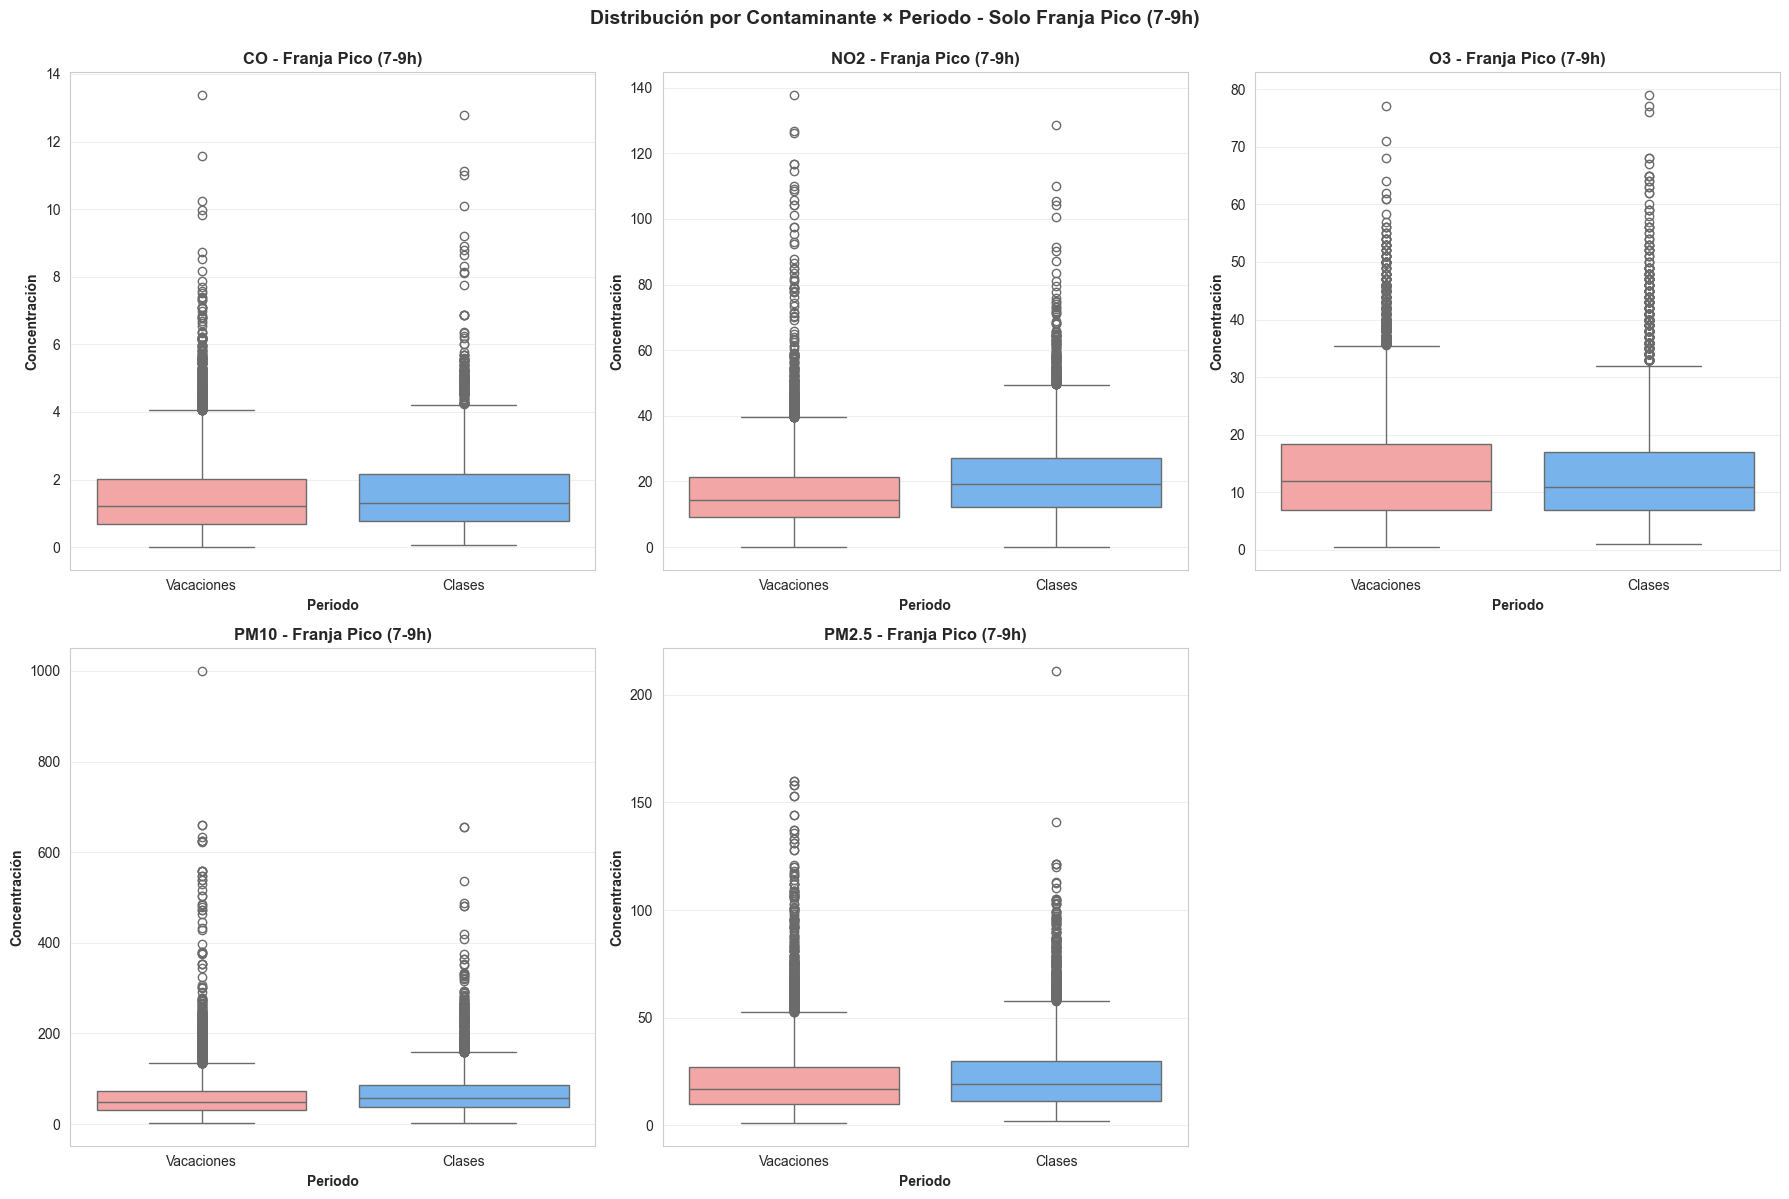

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

parametros_sorted_pico = sorted(df_pico['parametro'].unique())

for idx, param in enumerate(parametros_sorted_pico):
    data_param = df_pico[df_pico['parametro'] == param]
    
    sns.boxplot(data=data_param, x='clase', y='valor', 
                palette=['#ff9999', '#66b3ff'], ax=axes[idx])
    
    axes[idx].set_title(f'{param} - Franja Pico (7-9h)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Periodo', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Concentración', fontsize=10, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_xticklabels(['Vacaciones', 'Clases'])

# Ocultar ejes extras
for idx in range(len(parametros_sorted_pico), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribución por Contaminante × Periodo - Solo Franja Pico (7-9h)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 15.12 Matriz de correlación entre contaminantes

In [69]:
# Crear tabla pivot para correlación
pivot_pico = df_pico.pivot_table(
    index='date', 
    columns='parametro', 
    values='valor', 
    aggfunc='mean'
)

print("=" * 70)
print("TABLA PIVOT - SOLO FRANJA PICO (7-9h)")
print("=" * 70)
print(f"Forma de la tabla: {pivot_pico.shape}")
print(f"Fechas únicas: {len(pivot_pico)}")
print(f"Contaminantes: {list(pivot_pico.columns)}")
print("=" * 70)

# Calcular correlación
contaminantes_interes_pico = ['CO', 'NO2', 'PM10', 'PM2.5', 'O3']
correlacion_pico = pivot_pico[contaminantes_interes_pico].corr()

print("\n" + "=" * 70)
print("MATRIZ DE CORRELACIÓN ENTRE CONTAMINANTES - FRANJA PICO (7-9h)")
print("=" * 70)
print(correlacion_pico.round(3))
print("=" * 70)

# Estadísticas de correlación
print("\nEstadísticas de correlación:")
print(f"  • Correlación promedio: {correlacion_pico.values[np.triu_indices_from(correlacion_pico.values, k=1)].mean():.3f}")
print(f"  • Correlación máxima: {correlacion_pico.values[np.triu_indices_from(correlacion_pico.values, k=1)].max():.3f}")
print(f"  • Correlación mínima: {correlacion_pico.values[np.triu_indices_from(correlacion_pico.values, k=1)].min():.3f}")

# Pares con mayor correlación
print("\nPares con mayor correlación en franja pico:")
corr_pairs_pico = []
for i in range(len(correlacion_pico.columns)):
    for j in range(i+1, len(correlacion_pico.columns)):
        corr_pairs_pico.append((correlacion_pico.columns[i], correlacion_pico.columns[j], correlacion_pico.iloc[i, j]))
corr_pairs_sorted_pico = sorted(corr_pairs_pico, key=lambda x: abs(x[2]), reverse=True)
for par1, par2, corr_val in corr_pairs_sorted_pico[:5]:
    print(f"  • {par1} - {par2}: {corr_val:.3f}")

TABLA PIVOT - SOLO FRANJA PICO (7-9h)
Forma de la tabla: (1824, 5)
Fechas únicas: 1824
Contaminantes: ['CO', 'NO2', 'O3', 'PM10', 'PM2.5']

MATRIZ DE CORRELACIÓN ENTRE CONTAMINANTES - FRANJA PICO (7-9h)
parametro     CO    NO2   PM10  PM2.5     O3
parametro                                   
CO         1.000  0.437  0.480  0.547 -0.134
NO2        0.437  1.000  0.577  0.440 -0.393
PM10       0.480  0.577  1.000  0.745 -0.201
PM2.5      0.547  0.440  0.745  1.000 -0.255
O3        -0.134 -0.393 -0.201 -0.255  1.000

Estadísticas de correlación:
  • Correlación promedio: 0.224
  • Correlación máxima: 0.745
  • Correlación mínima: -0.393

Pares con mayor correlación en franja pico:
  • PM10 - PM2.5: 0.745
  • NO2 - PM10: 0.577
  • CO - PM2.5: 0.547
  • CO - PM10: 0.480
  • NO2 - PM2.5: 0.440


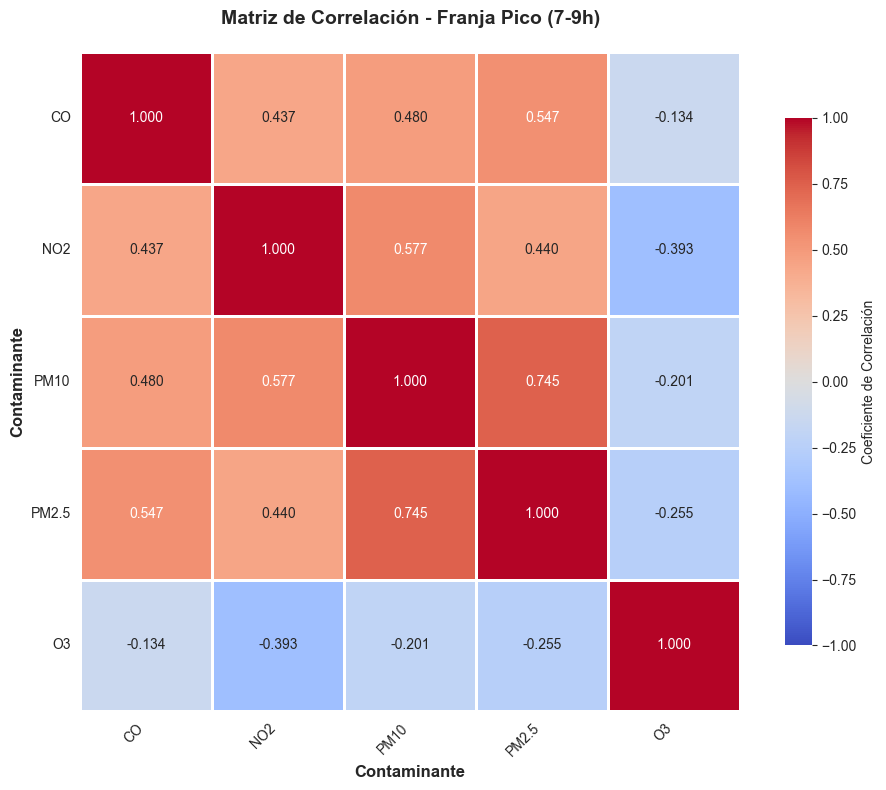

In [70]:
# Heatmap de correlación - Solo pico
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlacion_pico, 
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={'label': 'Coeficiente de Correlación', 'shrink': 0.8},
            vmin=-1, 
            vmax=1,
            ax=ax)

ax.set_title('Matriz de Correlación - Franja Pico (7-9h)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Contaminante', fontsize=12, fontweight='bold')
ax.set_ylabel('Contaminante', fontsize=12, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

### 15.13 Análisis de simetría y forma de distribución

In [71]:
from scipy import stats

print("=" * 80)
print("ANÁLISIS DE SIMETRÍA - SOLO FRANJA PICO (7-9h)")
print("=" * 80)

resultados_simetria_pico = []

for param in sorted(df_pico['parametro'].unique()):
    datos_param = df_pico[df_pico['parametro'] == param]['valor']
    
    skewness = stats.skew(datos_param)
    kurtosis = stats.kurtosis(datos_param, fisher=False)
    
    # Interpretar skewness
    if abs(skewness) < 0.5:
        interp_skew = "Simétrica"
    elif skewness > 0:
        interp_skew = "Asimétrica positiva"
    else:
        interp_skew = "Asimétrica negativa"
    
    # Interpretar kurtosis
    if 2.5 < kurtosis < 3.5:
        interp_kurt = "Normal"
    elif kurtosis > 3.5:
        interp_kurt = "Leptocúrtica"
    else:
        interp_kurt = "Platicúrtica"
    
    resultados_simetria_pico.append({
        'Contaminante': param,
        'Skewness': round(skewness, 3),
        'Interpretación': interp_skew,
        'Kurtosis': round(kurtosis, 3),
        'Forma': interp_kurt
    })

df_simetria_pico = pd.DataFrame(resultados_simetria_pico)
print(df_simetria_pico.to_string(index=False))
print("=" * 80)

ANÁLISIS DE SIMETRÍA - SOLO FRANJA PICO (7-9h)
Contaminante  Skewness      Interpretación  Kurtosis        Forma
          CO     1.492 Asimétrica positiva     8.113 Leptocúrtica
         NO2     1.503 Asimétrica positiva     9.267 Leptocúrtica
          O3     1.352 Asimétrica positiva     5.500 Leptocúrtica
        PM10     3.340 Asimétrica positiva    32.681 Leptocúrtica
       PM2.5     2.012 Asimétrica positiva    10.836 Leptocúrtica


### 15.14 Resumen comparativo: Media y Varianza por contaminante

In [72]:
print("\n" + "="*90)
print("RESUMEN COMPARATIVO - MEDIA Y VARIANZA POR CONTAMINANTE (FRANJA PICO 7-9h)")
print("="*90)

resumen_pico = df_pico.groupby('parametro')['valor'].agg(['mean', 'var', 'std', 'min', 'max']).round(3)
resumen_pico.columns = ['Media', 'Varianza', 'Desv. Estándar', 'Mínimo', 'Máximo']
resumen_pico = resumen_pico.sort_values('Media', ascending=False)

print(resumen_pico.to_string())
print("="*90)

# Coeficiente de variación
cv_pico = (resumen_pico['Desv. Estándar'] / resumen_pico['Media'] * 100).round(2)
print("\nCoeficiente de Variación (CV) por contaminante:")
print("(Indica variabilidad relativa: CV alto = más dispersión)")
print("-" * 90)
for param in cv_pico.sort_values(ascending=False).index:
    print(f"  {param:8s}:  {cv_pico[param]:6.2f}%")
print("="*90)


RESUMEN COMPARATIVO - MEDIA Y VARIANZA POR CONTAMINANTE (FRANJA PICO 7-9h)
            Media  Varianza  Desv. Estándar  Mínimo   Máximo
parametro                                                   
PM10       61.058  1813.959          42.591     2.0  1000.00
PM2.5      21.412   238.274          15.436     1.0   211.06
NO2        17.741   110.875          10.530     0.0   137.80
O3         13.560    80.423           8.968     0.5    79.00
CO          1.481     0.994           0.997     0.0    13.38

Coeficiente de Variación (CV) por contaminante:
(Indica variabilidad relativa: CV alto = más dispersión)
------------------------------------------------------------------------------------------
  PM2.5   :   72.09%
  PM10    :   69.75%
  CO      :   67.32%
  O3      :   66.14%
  NO2     :   59.35%


### 15.15 Gráficos comparativos: Media y Varianza

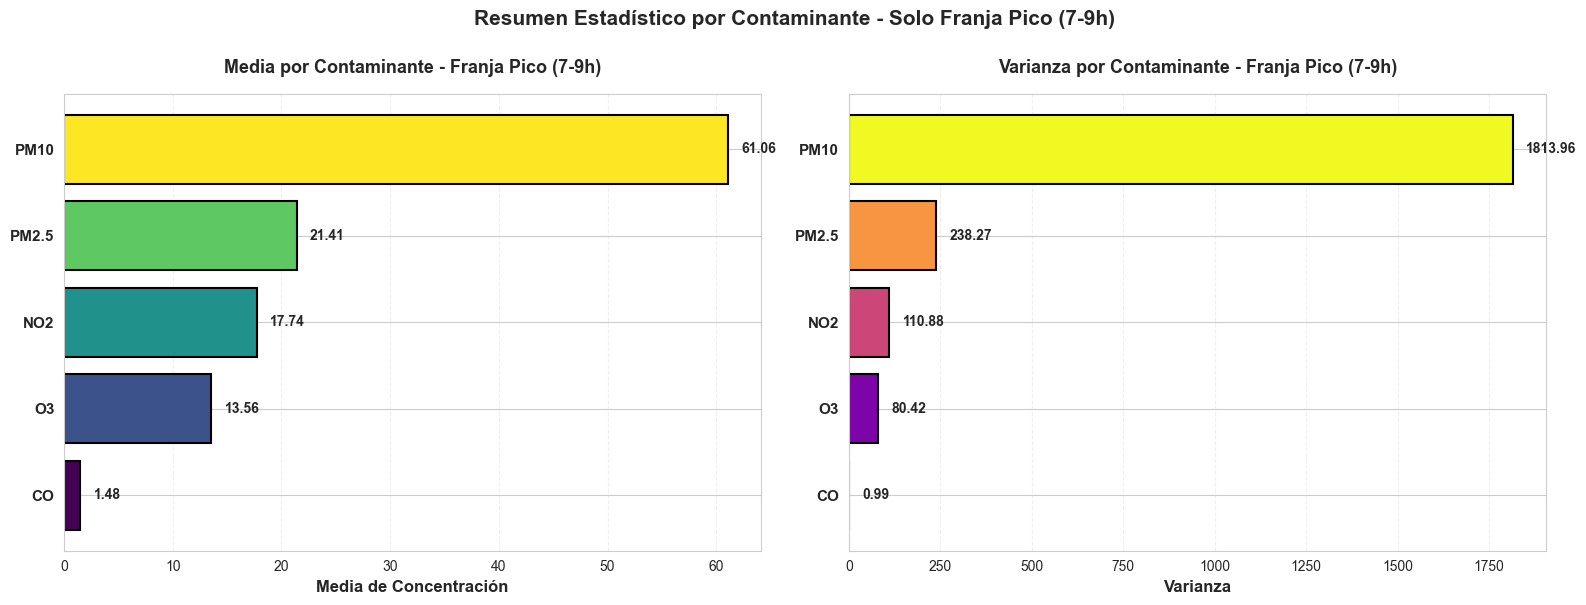

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Media por contaminante
ax1 = axes[0]
resumen_pico_sorted = resumen_pico.sort_values('Media', ascending=True)
colors_media = plt.cm.viridis(np.linspace(0, 1, len(resumen_pico_sorted)))
bars1 = ax1.barh(range(len(resumen_pico_sorted)), resumen_pico_sorted['Media'], 
                 color=colors_media, edgecolor='black', linewidth=1.5)
ax1.set_yticks(range(len(resumen_pico_sorted)))
ax1.set_yticklabels(resumen_pico_sorted.index, fontsize=11, fontweight='bold')
ax1.set_xlabel('Media de Concentración', fontsize=12, fontweight='bold')
ax1.set_title('Media por Contaminante - Franja Pico (7-9h)', fontsize=13, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Añadir valores en las barras
for idx, (val, bar) in enumerate(zip(resumen_pico_sorted['Media'], bars1)):
    ax1.text(val + max(resumen_pico_sorted['Media'])*0.02, idx, f'{val:.2f}', 
             va='center', fontsize=10, fontweight='bold')

# Gráfico 2: Varianza por contaminante
ax2 = axes[1]
resumen_pico_var_sorted = resumen_pico.sort_values('Varianza', ascending=True)
colors_var = plt.cm.plasma(np.linspace(0, 1, len(resumen_pico_var_sorted)))
bars2 = ax2.barh(range(len(resumen_pico_var_sorted)), resumen_pico_var_sorted['Varianza'], 
                 color=colors_var, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(resumen_pico_var_sorted)))
ax2.set_yticklabels(resumen_pico_var_sorted.index, fontsize=11, fontweight='bold')
ax2.set_xlabel('Varianza', fontsize=12, fontweight='bold')
ax2.set_title('Varianza por Contaminante - Franja Pico (7-9h)', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Añadir valores en las barras
for idx, (val, bar) in enumerate(zip(resumen_pico_var_sorted['Varianza'], bars2)):
    ax2.text(val + max(resumen_pico_var_sorted['Varianza'])*0.02, idx, f'{val:.2f}', 
             va='center', fontsize=10, fontweight='bold')

plt.suptitle('Resumen Estadístico por Contaminante - Solo Franja Pico (7-9h)', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 15.15 Gráficos de barras y pastel

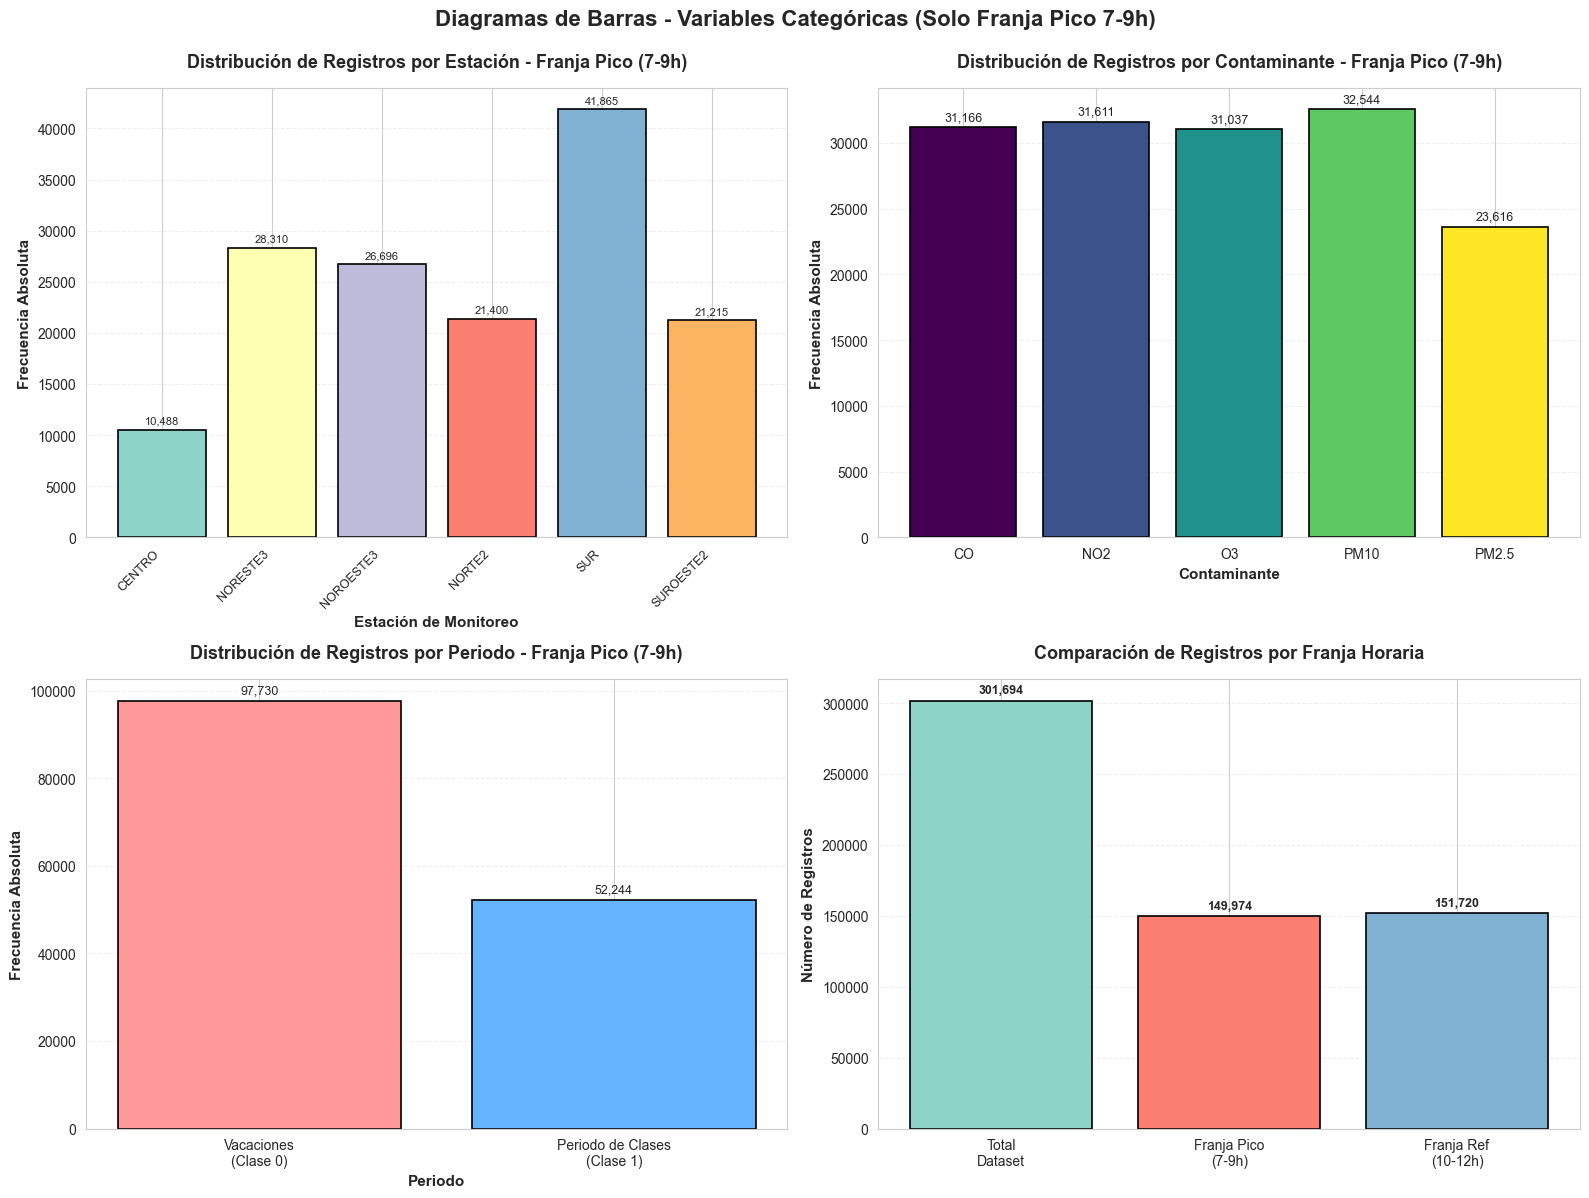

In [74]:
# Gráficos de barras para variables categóricas - Solo franja pico (7-9h)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Frecuencia por Estación
ax1 = axes[0, 0]
freq_est_pico = df_pico['estacion'].value_counts().sort_index()
colors_est = plt.cm.Set3(range(len(freq_est_pico)))
ax1.bar(range(len(freq_est_pico)), freq_est_pico.values, color=colors_est, edgecolor='black', linewidth=1.2)
ax1.set_xticks(range(len(freq_est_pico)))
ax1.set_xticklabels(freq_est_pico.index, rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Frecuencia Absoluta', fontsize=11, fontweight='bold')
ax1.set_xlabel('Estación de Monitoreo', fontsize=11, fontweight='bold')
ax1.set_title('Distribución de Registros por Estación - Franja Pico (7-9h)', fontsize=13, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(freq_est_pico.values):
    ax1.text(i, v + max(freq_est_pico.values)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=8)

# 2. Frecuencia por Parámetro
ax2 = axes[0, 1]
freq_param_pico = df_pico['parametro'].value_counts().sort_index()
colors_param = plt.cm.viridis(np.linspace(0, 1, len(freq_param_pico)))
ax2.bar(range(len(freq_param_pico)), freq_param_pico.values, color=colors_param, edgecolor='black', linewidth=1.2)
ax2.set_xticks(range(len(freq_param_pico)))
ax2.set_xticklabels(freq_param_pico.index, fontsize=10)
ax2.set_ylabel('Frecuencia Absoluta', fontsize=11, fontweight='bold')
ax2.set_xlabel('Contaminante', fontsize=11, fontweight='bold')
ax2.set_title('Distribución de Registros por Contaminante - Franja Pico (7-9h)', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(freq_param_pico.values):
    ax2.text(i, v + max(freq_param_pico.values)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=9)

# 3. Frecuencia por Clase
ax3 = axes[1, 0]
freq_clase_pico = df_pico['clase'].value_counts().sort_index()
colors_clase = ['#ff9999', '#66b3ff']
ax3.bar(range(len(freq_clase_pico)), freq_clase_pico.values, color=colors_clase, edgecolor='black', linewidth=1.2)
ax3.set_xticks(range(len(freq_clase_pico)))
etiquetas_clase = ['Vacaciones\n(Clase 0)', 'Periodo de Clases\n(Clase 1)']
ax3.set_xticklabels(etiquetas_clase, fontsize=10)
ax3.set_ylabel('Frecuencia Absoluta', fontsize=11, fontweight='bold')
ax3.set_xlabel('Periodo', fontsize=11, fontweight='bold')
ax3.set_title('Distribución de Registros por Periodo - Franja Pico (7-9h)', fontsize=13, fontweight='bold', pad=15)
ax3.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(freq_clase_pico.values):
    ax3.text(i, v + max(freq_clase_pico.values)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=9)

# 4. Comparación Total de Registros
ax4 = axes[1, 1]
total_original = len(df)
total_pico = len(df_pico)
total_ref = len(df) - len(df_pico)
ax4.bar(['Total\nDataset', 'Franja Pico\n(7-9h)', 'Franja Ref\n(10-12h)'], 
        [total_original, total_pico, total_ref],
        color=['#8dd3c7', '#fb8072', '#80b1d3'], 
        edgecolor='black', linewidth=1.2)
ax4.set_ylabel('Número de Registros', fontsize=11, fontweight='bold')
ax4.set_title('Comparación de Registros por Franja Horaria', fontsize=13, fontweight='bold', pad=15)
ax4.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate([total_original, total_pico, total_ref]):
    ax4.text(i, v + max([total_original, total_pico, total_ref])*0.01, f'{v:,}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Diagramas de Barras - Variables Categóricas (Solo Franja Pico 7-9h)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 15.16 Resumen de hallazgos clave

In [75]:
print("\n" + "="*90)
print("HALLAZGOS CLAVE - ANÁLISIS EXPLORATORIO FRANJA PICO (7-9h)")
print("="*90)

print("\n1. ESTACIÓN CON MAYOR CONTAMINACIÓN PROMEDIO:")
print(stats_pico_estacion['media'].sort_values(ascending=False).head(3).to_string())

print("\n2. CONTAMINANTE CON MAYOR CONCENTRACIÓN PROMEDIO:")
print(stats_pico_parametro['media'].sort_values(ascending=False).to_string())

print("\n3. DIFERENCIA ENTRE PERIODOS DE CLASES Y VACACIONES:")
diff_clase = stats_pico_clase.loc[1, 'media'] - stats_pico_clase.loc[0, 'media']
pct_diff = (diff_clase / stats_pico_clase.loc[0, 'media']) * 100
print(f"   • Vacaciones (Clase 0):       {stats_pico_clase.loc[0, 'media']:.2f}")
print(f"   • Periodo de clases (Clase 1): {stats_pico_clase.loc[1, 'media']:.2f}")
print(f"   • Diferencia:                  {diff_clase:.2f} ({pct_diff:+.2f}%)")

print("\n4. VARIABILIDAD POR CONTAMINANTE (Coef. de Variación):")
for param, cv_val in cv_pico.sort_values(ascending=False).head(5).items():
    print(f"   • {param:8s}: {cv_val:6.2f}%")

print("\n5. CONTAMINANTE MÁS ESTABLE (menor variabilidad):")
print(f"   • {cv_pico.idxmin()}: {cv_pico.min():.2f}%")

print("\n6. ESTACIONES CON MAYOR VARIABILIDAD:")
cv_estacion_pico = (stats_pico_estacion['desv_std'] / stats_pico_estacion['media'] * 100).sort_values(ascending=False)
for est, cv_val in cv_estacion_pico.head(3).items():
    print(f"   • {est}: {cv_val:.2f}%")

print("\n" + "="*90)


HALLAZGOS CLAVE - ANÁLISIS EXPLORATORIO FRANJA PICO (7-9h)

1. ESTACIÓN CON MAYOR CONTAMINACIÓN PROMEDIO:
estacion
SUROESTE2    25.224042
CENTRO       24.895934
NORTE2       24.733400

2. CONTAMINANTE CON MAYOR CONCENTRACIÓN PROMEDIO:
parametro
PM10     61.057875
PM2.5    21.411638
NO2      17.740910
O3       13.559838
CO        1.481237

3. DIFERENCIA ENTRE PERIODOS DE CLASES Y VACACIONES:
   • Vacaciones (Clase 0):       22.48
   • Periodo de clases (Clase 1): 25.33
   • Diferencia:                  2.85 (+12.66%)

4. VARIABILIDAD POR CONTAMINANTE (Coef. de Variación):
   • PM2.5   :  72.09%
   • PM10    :  69.75%
   • CO      :  67.32%
   • O3      :  66.14%
   • NO2     :  59.35%

5. CONTAMINANTE MÁS ESTABLE (menor variabilidad):
   • NO2: 59.35%

6. ESTACIONES CON MAYOR VARIABILIDAD:
   • NORESTE3: 134.67%
   • SUR: 129.92%
   • NOROESTE3: 129.64%

